# Overview

This notebook demonstrates how to parse the FIA documents. We documents how to parse “Race Lap Analysis” in detail, and then move to all other docs later.

In [1]:
import re

import fitz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Some aesthetic settings
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
rc = {'figure.figsize': (4, 3),
      'axes.facecolor': 'white',             # Remove background colour
      'axes.grid' : False,                   # Turn on grid
      'axes.linewidth': '0.2',
      'axes.edgecolor': '0',                 # Set axes edge color to be black
      'font.size': 2,
      'xtick.major.size': 1,
      'xtick.major.width': 0.2,
      'ytick.major.size': 1,
      'ytick.major.width': 0.2}
plt.rcdefaults()
plt.rcParams.update(rc)


def show_image(item):
    """Display a pixmap

    :param item: Any PyMuPDF object having a "get_pixmap" method

    Just to display Pixmap image of "item" - ignore the man behind the curtain. Generates an RGB
    pixmap from item using a constant DPI and using matplotlib to show it inline of the notebook
    """
    DPI = 300
    pix = item.get_pixmap(dpi=DPI)
    img = np.ndarray([pix.h, pix.w, 3], dtype=np.uint8, buffer=pix.samples_mv)
    plt.figure(dpi=DPI)
    _ = plt.imshow(img, extent=(0, pix.w * 72 / DPI, pix.h * 72 / DPI, 0))
    pass

# Pre-race

We have some info. before the weekend starts, e.g. the mapping between "soft" to the underlying Cx compound, driver entry list, etc. We will parse these info. first.

## Entry list

We need a mapping between car number, driver (full) name, and team (full) name, so we can merge them into the database later easily.

The PDF is relative hard to parse. The very first page (steward names) can be skipped, and the second page (and maybe also the later pages if we have too many drivers that cannot be fit into one page) contains the info. we need. There is no lines separating the rows or cols, and there are actually multiple tables: one for the drivers, and the other(s) for reserve drivers. `pymupdf` cannot handle this well, even if we manually specify the col. locations, so we rely on `camelot` instead. Another reason for `camelot` is the superscripts, which `pymupdf` also doesn't handle well. Funnily, `camelot` is not able to search for text, so we cannot set the coordinates of the bounding box/table region to extract. In the end, we use `pymupdf` to search for the texts so that we get the top left and bottom right coordinates of the table, and then use `camelot` to extract the tables. Note that the two packages use different coordinate systems: see [https://camelot-py.readthedocs.io/en/master/user/advanced.html#specify-table-areas](https://camelot-py.readthedocs.io/en/master/user/advanced.html#specify-table-areas) and [https://pymupdf.readthedocs.io/en/latest/page.html#Page.derotation_matrix](https://pymupdf.readthedocs.io/en/latest/page.html#Page.derotation_matrix).

In [2]:
def extract_table_from_bbox(page, bbox):
    blocks = page.get_text("dict", clip=bbox)["blocks"]
    rows = {}
    last_y0 = None
    tolerance = 5

    for block in blocks:
        if "lines" not in block:
            continue
        for line in block["lines"]:
            for span in line["spans"]:
                x0, y0, x1, y1 = span["bbox"]
                if last_y0 is not None and abs(y0 - last_y0) <= tolerance:
                    y0 = last_y0
                else:
                    tolerance = max(5, (y1 - y0) / 2)
                row_key = round(y0, -1)
                last_y0 = y0
                if row_key not in rows:
                    rows[row_key] = []
                rows[row_key].append((x0, span["text"].strip()))

    sorted_rows = sorted(rows.items(), key=lambda item: item[0])
    table = []
    for _, row_blocks in sorted_rows:
        sorted_row = sorted(row_blocks, key=lambda b: b[0])
        row_data = [text for _, text in sorted_row if text]
        if len(row_data) == 6:
            row_data = row_data[0:1] + row_data[2:]
        table.append(row_data)

    return table


In [3]:
doc = fitz.open('../fia_pdfs/entry_list.pdf')
page = doc[1]
w = page.bound()[2]
h = page.bound()[3]

# Find "No.", which is the top left corner of the table
text = page.search_for('No.')[0]
top_left = (text.x0, text.y0)

# The "right" is easy, which is simply the rightmost edge of the page, but the "bottom" is less so
# We iteratively search vertically downwards from "No.", until we cannot find anything
text_height = (text.y1 - text.y0)*1.035  # The line spacing seems to be roughly 1.035
top = text.y0 + text_height
bottom = text.y1 + text_height  # Give it a little buffer
no_left = text.x0
no_right = text.x1
while top < h:
    text = page.get_text('text', clip=(no_left, top, no_right, bottom))
    if text.strip():
        top += text_height
        bottom += text_height
    else:  # If find nothing, that's the end of the table
        break
bottom_right = (w, top)

# Flip the y axis so we have the coordiates for `camelot`
top_left = (int(top_left[0]), int(h - top_left[1]))
bottom_right = (int(bottom_right[0]), int(h - bottom_right[1]) + 1)

# Parse using `pymupdf`
bbox = (top_left[0], h - top_left[1], bottom_right[0], h - bottom_right[1])
table_data = extract_table_from_bbox(page, bbox)

processed_data = [row for row in table_data if len(row) == 5]
drivers_df = pd.DataFrame(processed_data[1:], columns=processed_data[0])
drivers_df.head()

No.           Driver  Nat                           Team  \
0   1   Max Verstappen  NLD         Oracle Red Bull Racing   
1  11     Sergio Perez  MEX         Oracle Red Bull Racing   
2  16  Charles Leclerc  MCO               Scuderia Ferrari   
3  55     Carlos Sainz  ESP               Scuderia Ferrari   
4  63   George Russell  GBR  Mercedes-AMG PETRONAS F1 Team   

                  Constructor  
0  Red Bull Racing Honda RBPT  
1  Red Bull Racing Honda RBPT  
2                     Ferrari  
3                     Ferrari  
4                    Mercedes

Looks fine. The "1.035" line spacing is very fishy... Can break later so need to improve.

In [4]:
# Extract reserve drivers
top += text_height
bottom += text_height
while top < h:
    text = page.get_text("text", clip=(no_left, top, no_right, bottom))
    if text.strip():
        top += text_height
        bottom += text_height
    else:
        break
top_left = (no_left, bottom)
top += text_height
bottom = h
while top < h:
    text = page.get_text("text", clip=(no_left, top, no_right, bottom))
    if text.strip():
        top += text_height
        bottom += text_height
    else:
        break
bottom_right = (w, top)
top_left = (int(top_left[0]), int(h - top_left[1]))
bottom_right = (int(bottom_right[0]), int(h - bottom_right[1]) + 1)
bbox = (top_left[0], h - top_left[1], bottom_right[0], h - bottom_right[1])
reserve_table_data = extract_table_from_bbox(page, bbox)

reserve_processed_data = [row for row in reserve_table_data if len(row) == 5]
reserve_df = pd.DataFrame(reserve_processed_data, columns=processed_data[0])
reserve_df["role"] = "reserve"
reserve_df.head()

No.             Driver  Nat                                   Team  \
0  39  Robert Shwartzman  ISR                       Scuderia Ferrari   
1  34   Felipe Drugovich  BRA  Aston Martin Aramco Cognizant F1 Team   
2  50     Oliver Bearman  GBR                 MoneyGram Haas F1 Team   
3  61        Jack Doohan  AUS                     BWT Alpine F1 Team   
4  29    Patricio O’Ward  MEX                        McLaren F1 Team   

                    Constructor     role  
0                       Ferrari  reserve  
1  Aston Martin Aramco Mercedes  reserve  
2                  Haas Ferrari  reserve  
3                Alpine Renault  reserve  
4              McLaren Mercedes  reserve

## Power Unit Allocations

The rows and columns aren't separated by lines but instead empty spaces. The parser searches for the unique character of "N°" and the last character of the file which is located at the bottom right corner to create the bounding box surrouding the "table". From there, the library is able to detect the horizontal and vertical separation by using `horizontal_strategy='text'` and by providing it the vertical lines.

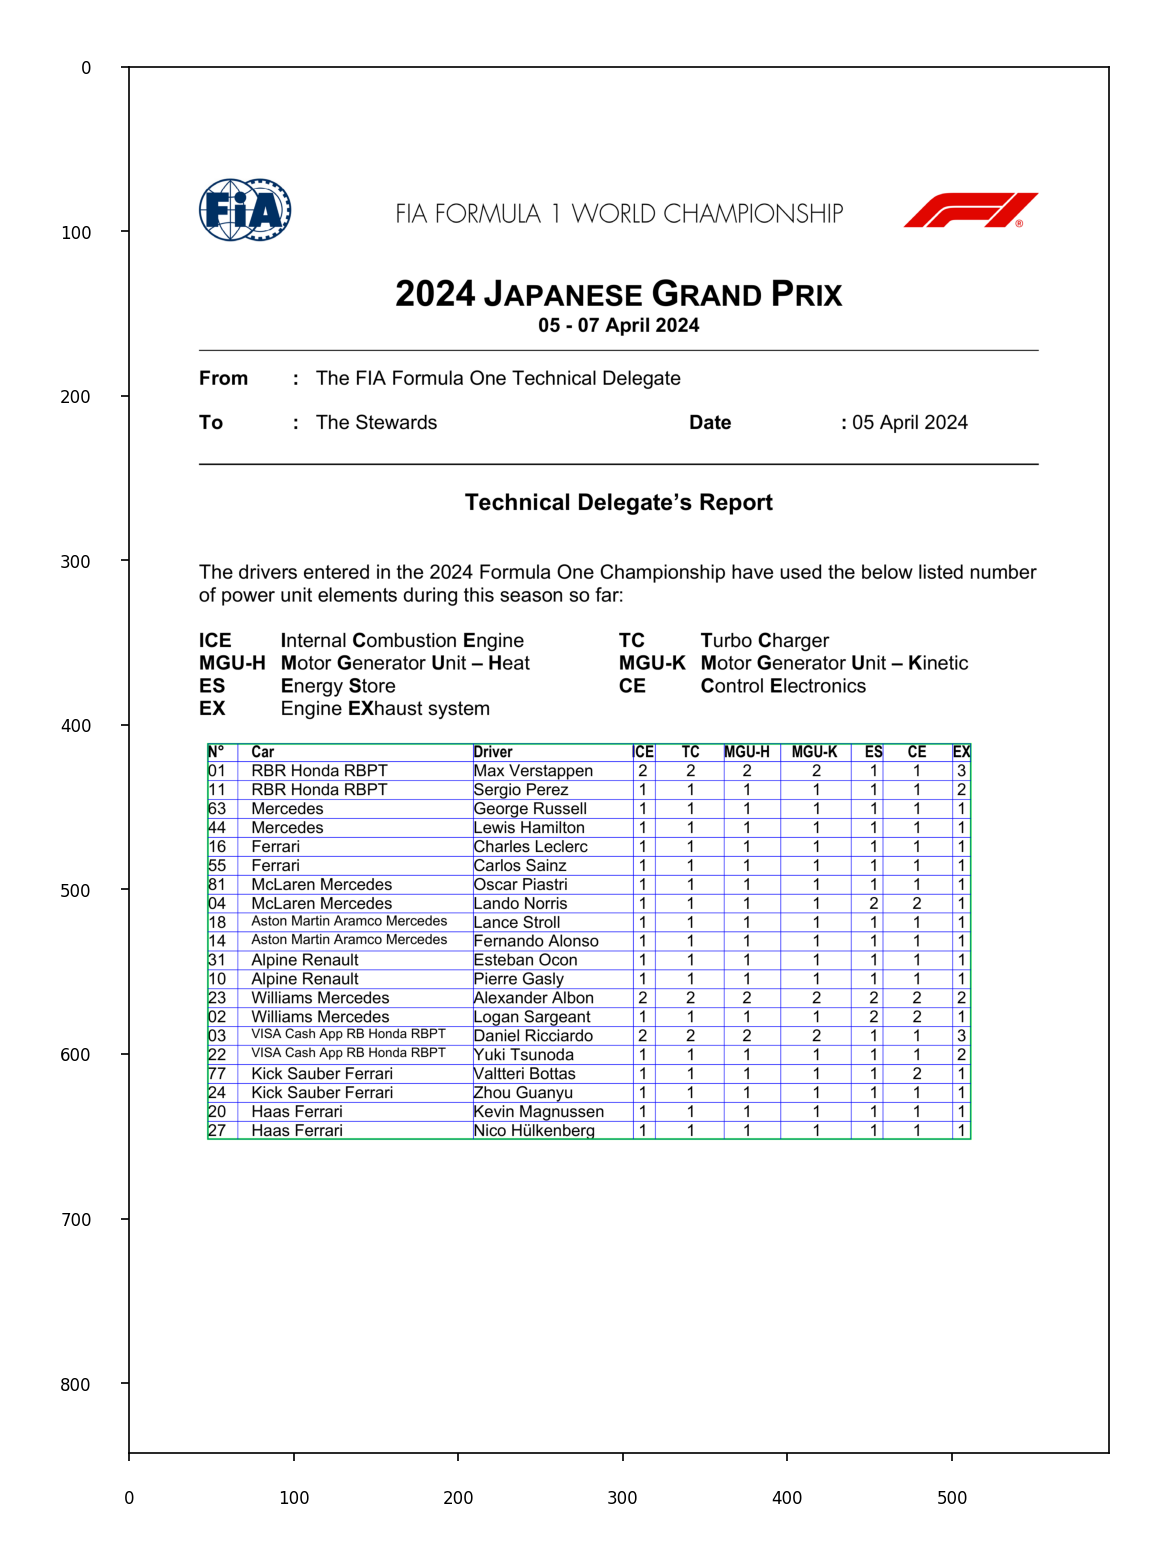

In [5]:
doc = fitz.open('../fia_pdfs/race_pu_elements_used.pdf')

# Find year/grand prix
page_0 = doc[0]

# Find "2024 Japanese Grand Prix" block
# The Block is a tuple with coordinates and text
text = page_0.get_text(option='blocks')
race = text[0][4].split()
year = race[0]
grand_prix = race[1:len(race)]
grand_prix_str = ' '.join(grand_prix).title()

# Find Power Unit components table
page_1 = doc[1]

# Search the bounding box for the N° character
number = page_1.search_for('N°')

# Find the very last character in the table
# at the bottom right
text = page_1.get_text().strip()
lc = text[-1]

# Search the last bounding box for the last character
char_bbox = page_1.search_for(lc)[-1]

# Create bounding box surrounding the entire table
# add 5% extra buffer to the right boundary
bbox = fitz.Rect(number[0].x0, number[0].y0, char_bbox.x1 * 1.05, char_bbox.y1)

# Create dictionary with the columns left/right most coordinates
pos = {}
for col in ['N°','Car','Driver', 'ICE', 'TC', 'MGU-H', 'MGU-K', 'ES', 'CE', 'EX']:
    pos[col] = {
        'left': page_1.search_for(col, clip=bbox)[0].x0,
        'right': page_1.search_for(col, clip=bbox)[0].x1
    }

# Some lines had to be adjusted to help the table detection
aux_lines = [
    pos['N°']['left'],
    (pos['N°']['right'] + pos['Car']['left']) / 2,
    pos['Driver']['left'],
    pos['ICE']['left'],
    (pos['ICE']['left'] + pos['TC']['left']) / 2,
    pos['MGU-H']['left'],
    (pos['MGU-H']['right'] + pos['MGU-K']['left']) / 2,
    (pos['MGU-K']['right'] + pos['ES']['left']) / 2,
    pos['ES']['right'],
    pos['CE']['left'],
    pos['CE']['right'],
    pos['EX']['left'],
    pos['EX']['right']
]

tabs = page_1.find_tables(
    clip=fitz.Rect(bbox),
    horizontal_strategy='text',
    vertical_lines=aux_lines,
)

# Mark the tables for visualisation
for j, tab in enumerate(tabs):  # iterate over all tables
    page_1.draw_rect(tab.bbox, color=fitz.pdfcolor['green'])
    # print(tab.header.cells)
    for cell in tab.header.cells:
        page_1.draw_rect(cell, color=fitz.pdfcolor['blue'], width=0.3)
    for cell in tab.cells:
        page_1.draw_rect(cell, color=fitz.pdfcolor['blue'], width=0.3)

show_image(page_1)

Manually add the parsed `Year` and `Grand Prix` to the dataframe.

In [6]:
df = tab.to_pandas()
df.insert(0, "Year", year)
df.insert(1, "Grand Prix", grand_prix_str)
display(df)

Year           Grand Prix  N°                           Car  \
0   2024  Japanese Grand Prix  01                RBR Honda RBPT   
1   2024  Japanese Grand Prix  11                RBR Honda RBPT   
2   2024  Japanese Grand Prix  63                      Mercedes   
3   2024  Japanese Grand Prix  44                      Mercedes   
4   2024  Japanese Grand Prix  16                       Ferrari   
5   2024  Japanese Grand Prix  55                       Ferrari   
6   2024  Japanese Grand Prix  81              McLaren Mercedes   
7   2024  Japanese Grand Prix  04              McLaren Mercedes   
8   2024  Japanese Grand Prix  18  Aston Martin Aramco Mercedes   
9   2024  Japanese Grand Prix  14  Aston Martin Aramco Mercedes   
10  2024  Japanese Grand Prix  31                Alpine Renault   
11  2024  Japanese Grand Prix  10                Alpine Renault   
12  2024  Japanese Grand Prix  23             Williams Mercedes   
13  2024  Japanese Grand Prix  02             Williams Mercedes   
14  2024  Japanese Grand Prix  03   VISA Cash App RB Honda RBPT   
15  2024  Japanese Grand Prix  22   VISA Cash App RB Honda RBPT   
16  2024  Japanese Grand Prix  77           Kick Sauber Ferrari   
17  2024  Japanese Grand Prix  24           Kick Sauber Ferrari   
18  2024  Japanese Grand Prix  20                  Haas Ferrari   
19  2024  Japanese Grand Prix  27                  Haas Ferrari   

              Driver ICE TC MGU-H MGU-K ES CE EX  
0     Max Verstappen   2  2     2     2  1  1  3  
1       Sergio Perez   1  1     1     1  1  1  2  
2     George Russell   1  1     1     1  1  1  1  
3     Lewis Hamilton   1  1     1     1  1  1  1  
4    Charles Leclerc   1  1     1     1  1  1  1  
5       Carlos Sainz   1  1     1     1  1  1  1  
6      Oscar Piastri   1  1     1     1  1  1  1  
7       Lando Norris   1  1     1     1  2  2  1  
8       Lance Stroll   1  1     1     1  1  1  1  
9    Fernando Alonso   1  1     1     1  1  1  1  
10      Esteban Ocon   1  1     1     1  1  1  1  
11      Pierre Gasly   1  1     1     1  1  1  1  
12   Alexander Albon   2  2     2     2  2  2  2  
13    Logan Sargeant   1  1     1     1  2  2  1  
14  Daniel Ricciardo   2  2     2     2  1  1  3  
15      Yuki Tsunoda   1  1     1     1  1  1  2  
16   Valtteri Bottas   1  1     1     1  1  2  1  
17       Zhou Guanyu   1  1     1     1  1  1  1  
18   Kevin Magnussen   1  1     1     1  1  1  1  
19   Nico Hülkenberg   1  1     1     1  1  1  1

# Quali

## Quali Final Classification

Very straightforward. Just locate the top and bottom location of the table, which is below the page title and above "NOT CLASSIFIED".

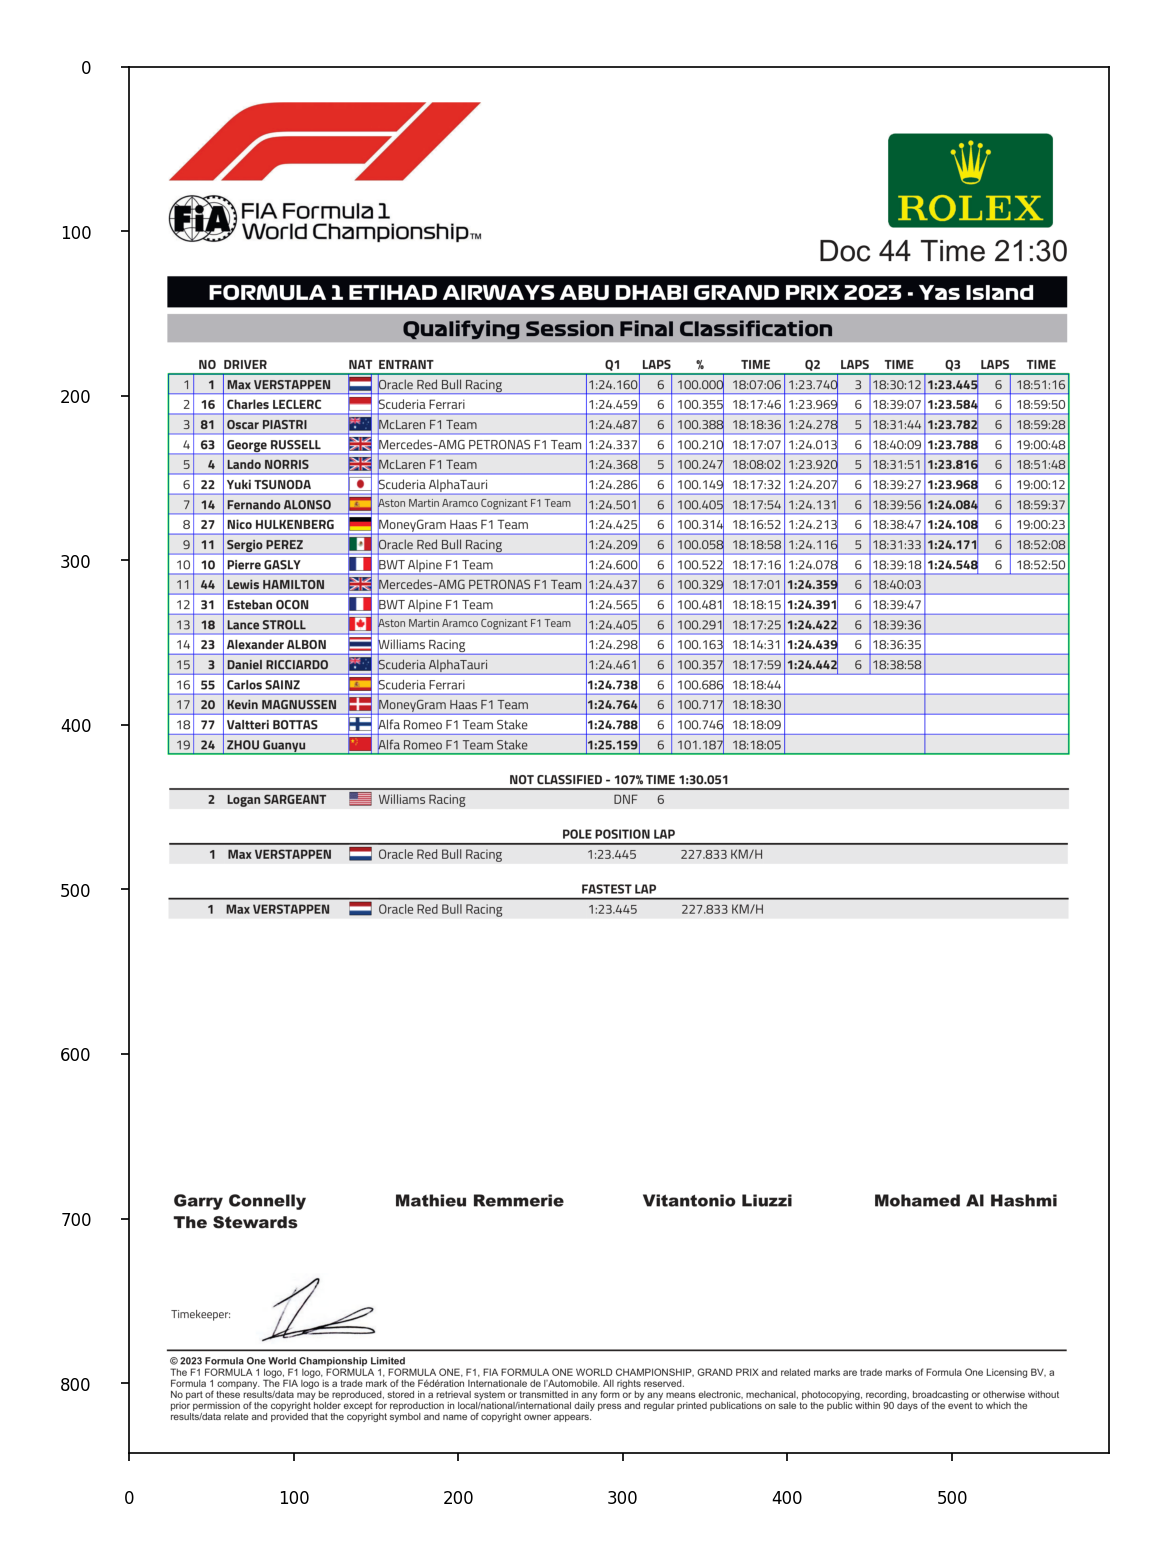

In [7]:
# Find the page with "Race Final Classification"
doc = fitz.open('../fia_pdfs/qualifying_final_classification.pdf')
for i in range(len(doc)):
    page = doc[i]
    found = page.search_for('Qualifying Session Final Classification')
    if found:
        break

# Width and height of the page
w, h = page.bound()[2], page.bound()[3]

# Position of "Qualifying Session Final Classification"
y = found[0].y1

# Position of "NOT CLASSIFIED - "
b = page.search_for('NOT CLASSIFIED - ')[0].y0

# Table bounding box
bbox = fitz.Rect(0, y, w, b)

# Find the table
tabs = page.find_tables(clip=bbox)

# Mark the tables for visualisation
for j, tab in enumerate(tabs):  # iterate over all tables
    page.draw_rect(tab.bbox, color=fitz.pdfcolor['green'])
    for cell in tab.header.cells:
        page.draw_rect(cell, color=fitz.pdfcolor['blue'], width=0.3)
    for cell in tab.cells:
        page.draw_rect(cell, color=fitz.pdfcolor['blue'], width=0.3)

show_image(page)

In [8]:
tabs[0].to_pandas()

0-1 1-1  2-Max VERSTAPPEN Col3 Col4               5-Oracle Red Bull Racing  \
0    2  16   Charles LECLERC                                 Scuderia Ferrari   
1    3  81     Oscar PIASTRI                                  McLaren F1 Team   
2    4  63    George RUSSELL                    Mercedes-AMG PETRONAS F1 Team   
3    5   4      Lando NORRIS                                  McLaren F1 Team   
4    6  22      Yuki TSUNODA                              Scuderia AlphaTauri   
5    7  14   Fernando ALONSO            Aston Martin Aramco Cognizant F1 Team   
6    8  27   Nico HULKENBERG                           MoneyGram Haas F1 Team   
7    9  11      Sergio PEREZ                           Oracle Red Bull Racing   
8   10  10      Pierre GASLY                               BWT Alpine F1 Team   
9   11  44    Lewis HAMILTON                    Mercedes-AMG PETRONAS F1 Team   
10  12  31      Esteban OCON                               BWT Alpine F1 Team   
11  13  18      Lance STROLL            Aston Martin Aramco Cognizant F1 Team   
12  14  23   Alexander ALBON                                  Williams Racing   
13  15   3  Daniel RICCIARDO                              Scuderia AlphaTauri   
14  16  55      Carlos SAINZ                                 Scuderia Ferrari   
15  17  20   Kevin MAGNUSSEN                           MoneyGram Haas F1 Team   
16  18  77   Valtteri BOTTAS                         Alfa Romeo F1 Team Stake   
17  19  24       ZHOU Guanyu                         Alfa Romeo F1 Team Stake   

   6-1:24.160 7-6 8-100.000 9-18:07:06 10-1:23.740  11-3 12-18:30:12  \
0    1:24.459   6   100.355   18:17:46    1:23.969     6    18:39:07   
1    1:24.487   6   100.388   18:18:36    1:24.278     5    18:31:44   
2    1:24.337   6   100.210   18:17:07    1:24.013     6    18:40:09   
3    1:24.368   5   100.247   18:08:02    1:23.920     5    18:31:51   
4    1:24.286   6   100.149   18:17:32    1:24.207     6    18:39:27   
5    1:24.501   6   100.405   18:17:54    1:24.131     6    18:39:56   
6    1:24.425   6   100.314   18:16:52    1:24.213     6    18:38:47   
7    1:24.209   6   100.058   18:18:58    1:24.116     5    18:31:33   
8    1:24.600   6   100.522   18:17:16    1:24.078     6    18:39:18   
9    1:24.437   6   100.329   18:17:01    1:24.359     6    18:40:03   
10   1:24.565   6   100.481   18:18:15    1:24.391     6    18:39:47   
11   1:24.405   6   100.291   18:17:25    1:24.422     6    18:39:36   
12   1:24.298   6   100.163   18:14:31    1:24.439     6    18:36:35   
13   1:24.461   6   100.357   18:17:59    1:24.442     6    18:38:58   
14   1:24.738   6   100.686   18:18:44              None        None   
15   1:24.764   6   100.717   18:18:30              None        None   
16   1:24.788   6   100.746   18:18:09              None        None   
17   1:25.159   6   101.187   18:18:05              None        None   

   13-1:23.445  14-6 15-18:51:16  
0     1:23.584     6    18:59:50  
1     1:23.782     6    18:59:28  
2     1:23.788     6    19:00:48  
3     1:23.816     6    18:51:48  
4     1:23.968     6    19:00:12  
5     1:24.084     6    18:59:37  
6     1:24.108     6    19:00:23  
7     1:24.171     6    18:52:08  
8     1:24.548     6    18:52:50  
9               None        None  
10              None        None  
11              None        None  
12              None        None  
13              None        None  
14              None        None  
15              None        None  
16              None        None  
17              None        None

## Quali. Lap Times

The layout is very similar to "Race Lap Analysis" below. But two tricky pointsL

1. lap times can be deleted, e.g. exceeding track limit. When a lap time is deleted, the text is crossed out. So we have to check if there is any strikethrough text (see [https://stackoverflow.com/a/74582342/12867291](https://stackoverflow.com/a/74582342/12867291))
1. one page has multiple drivers. We know that immediately below each driver, there must be at lease one "NO" and one "TIME". We can use this to locate the drivers

In [9]:
lines = []  # to be filled with horizontal "lines": thin rectangles
paths = page.get_drawings()  # list of drawing dictionary objects
for path in paths:  # dictionary with single draw commands
    for item in path["items"]:  # check item types
        if item[0] == "re":  # a rectangle, check if roughly a horizontal line
            rect = item[1]  # the item's rectangle
            if rect.width <= 2 * rect.height or rect.height > 1:
                continue  # not a pseudo-line
            lines.append(rect)


words = page.get_text("words")  # the words on the page
for rect in lines:
    for w in words:
        wrect = fitz.Rect(w[:4])  # rect of the word
        wtext = w[4]  # word text
        if wrect.intersects(rect):
            print(f"{wtext} is strike out")

Driver's number and name: ['2', 'Logan SARGEANT']


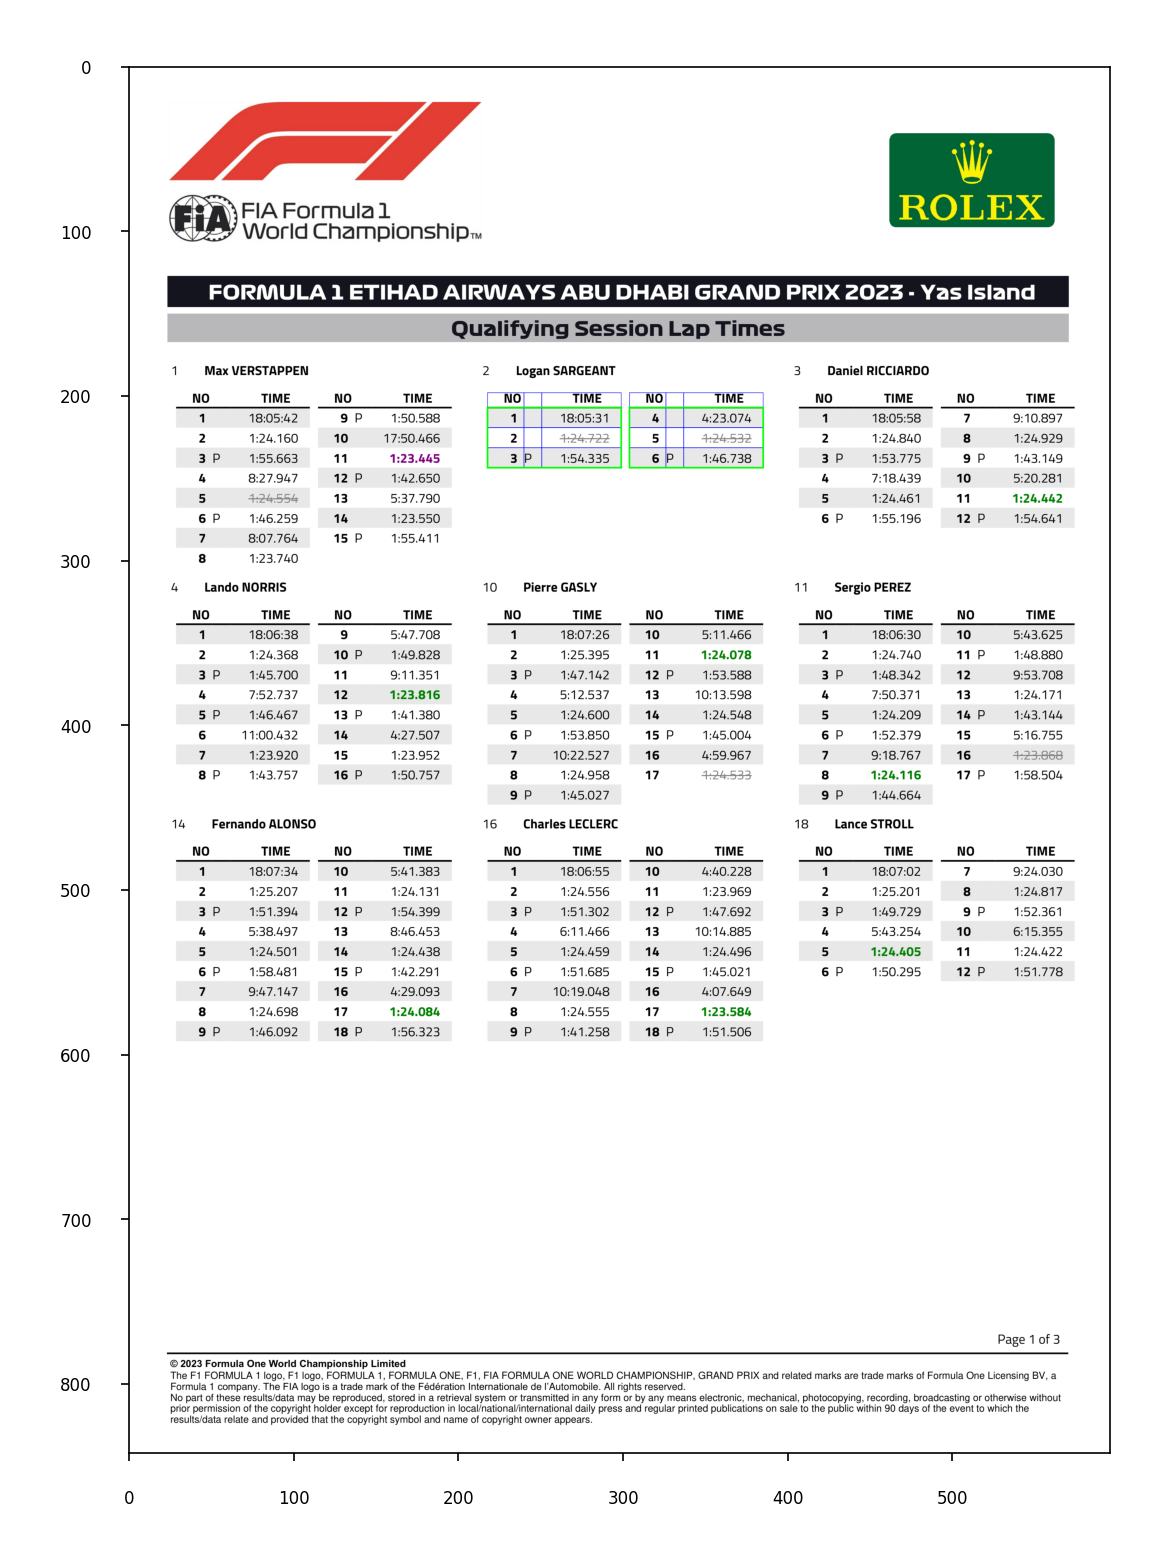

In [10]:
# Page width
doc = fitz.open('../fia_pdfs/qualifying_lap_times.pdf')
page = doc[0]
w = page.bound()[2]

# Position of "Qualifying Session Lap Times"
t = page.search_for('Qualifying Session Lap Times')[0].y1

# Positions of "NO" and "TIME"
no_pos = page.search_for('NO TIME')
ys = [i.y1 for i in no_pos]
ys.sort()
ts = [ys[0] - 1]  # Top of tables. -1 to give a little buffer
for y in ys[1:]:
    if y - ts[-1] > 10:   # Two "NO" should have some gap in between. If gap is small, they are the
        ts.append(y - 1)  # tables starting from the same position

# Bottom of the table is the next "NO TIME", or the bottom of the page
ys = [i.y0 for i in no_pos]
ys.sort()
bs = [ys[0]]
for y in ys[1:]:
    if y - bs[-1] > 10:
        bs.append(y)
bottom = page.search_for('Page')[-1].y0  # Bottom of the page
bs.append(bottom)
bs = bs[1:]

# Find the tables in row 1 col. 2 on page 1 (all 1-indexed)
page = doc[0]
for row in range(0, 1):
    for col in range(1, 2):

        # Find the driver name
        driver = page.get_text(
            'block',
            clip=fitz.Rect(col * w / 3, ts[row] - 30, (col + 1) * w / 3, ts[row] - 10)
        ).strip()
        print((f"Driver's number and name: {driver.split(maxsplit=1)}"))

        # Find tables in the bounding box of driver i's table
        tabs = page.find_tables(
            clip=fitz.Rect(col * w / 3, ts[row], (col + 1) * w / 3, bs[row]),
            strategy='lines'
        )

        # Mark the tables for visualisation
        for j, tab in enumerate(tabs):  # iterate over all tables
            for cell in tab.header.cells:
                page.draw_rect(cell,color=fitz.pdfcolor['blue'],width=0.3)
            for cell in tab.cells:
                page.draw_rect(cell,color=fitz.pdfcolor['blue'],width=0.3)
            page.draw_rect(tab.bbox, color=fitz.pdfcolor['green'])

show_image(page)

In [11]:
tabs[0].to_pandas()

NO Col1      TIME
0  1       18:05:31
1  2       1:24.722
2  3    P  1:54.335

In [12]:
tabs[1].to_pandas()

NO Col1      TIME
0  4       4:23.074
1  5       1:24.532
2  6    P  1:46.738

# Race

## Rap Lap Analysis

The high-level steps to process a page are as follows:

1. get the page width $w$. The width is shared by three drivers, so driver $i$’s table is roughly positioned between $\frac{i}{3}w$ and $\frac{i + 1}{3}w$ of the page width. $i$ is 0-indexed
1. get the position ($x, y$) of "Race Lap Analysis". The table will be below this position, i.e. the table's top coordinate is $y$
1. find the word "Page", which appears at the bottom of the page. Let its coordinates be $(a, b)$. The tables are above "Page", so their bottom coordinates are $b$
1. given driver $i$ and his table $i$’s bounding box $(\frac{i}{3}w, y, \frac{i + 1}{3}w, b)$, extract the table
1. the driver's name is above the table's header. So get the position of the table extracted above, and call the top coordinate $h$. The driver's name is vertically bounded between $y$ and $h$, and horizontally still bounded between $\frac{i}{3}w$ and $\frac{i + 1}{3}w$

<center><img src="../1.svg" width="50%"></center>

In [13]:
# Page width
doc = fitz.open('../fia_pdfs/race_lap_analysis.pdf')
page = doc[0]
w = page.bound()[2]

# Position of "Race Lap Analysis"
y = page.search_for('Race Lap Analysis')[0].y1

# Position of "Page"
b = page.search_for('Page')[0].y0

Driver 2's number and name: ['3', 'Daniel RICCIARDO']
Driver 2's table 0's col.: ['LAP', '', 'TIME']
Driver 2's table 1's col.: ['LAP', '', 'TIME']


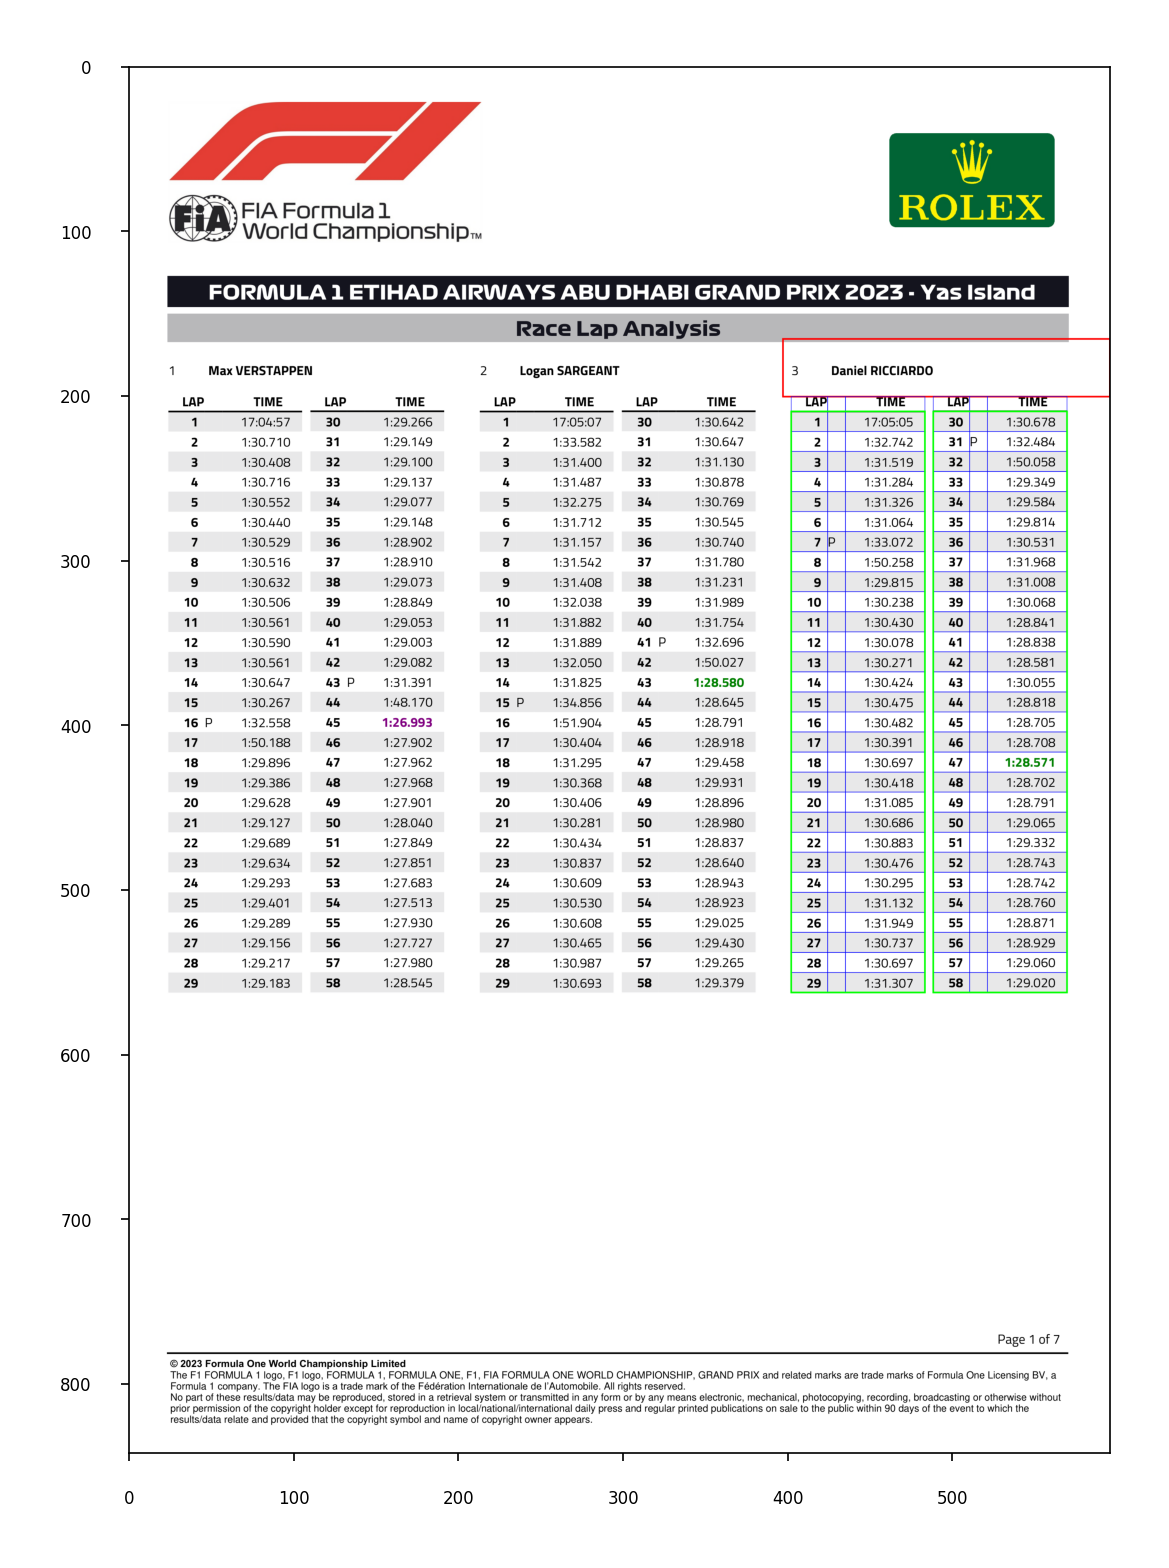

In [14]:
# Find the tables for the third driver (Ric) in page 1
page = doc[0]
for i in range(2, 3):

    # Find tables in the bounding box of driver i's table
    tabs = page.find_tables(clip=fitz.Rect(i * w / 3, y, (i + 1) * w / 3, b), strategy='lines')

    # Find the position of a table' header
    h = tabs[0].header.bbox[1]

    # The driver's name is between `h` and `y`
    name = page.get_text('block', clip=fitz.Rect(i * w / 3, y, (i + 1) * w / 3, h)).strip()
    page.draw_rect(fitz.Rect(i * w / 3, y, (i + 1) * w / 3, h), color=fitz.pdfcolor['red'])
    print((f"Driver {i}'s number and name: {name.split(maxsplit=1)}"))

    # Mark the tables for visualisation
    for j, tab in enumerate(tabs):  # iterate over all tables
        for cell in tab.header.cells:
            page.draw_rect(cell,color=fitz.pdfcolor['blue'],width=0.3)
        for cell in tab.cells:
            page.draw_rect(cell,color=fitz.pdfcolor['blue'],width=0.3)
        page.draw_rect(tab.bbox, color=fitz.pdfcolor['green'])
        print(f"Driver {i}'s table {j}'s col.: {tab.header.names}")

show_image(page)

In [15]:
tabs[0].to_pandas().head()

LAP Col1      TIME
0   1       17:05:05
1   2       1:32.742
2   3       1:31.519
3   4       1:31.284
4   5       1:31.326

## Race Final Classification

### Race Final Classification

Go through all pages, and stop when we find "Race Final Classification". The table is on that page, positioned below "Race Final Classification" and above "FASTEST LAP". For some reasons, the automatic parsing can be wrong for certain columns (e.g. "NAT") or rows (e.g. first row with missing "GAP" and "INT" will have mis-positioned cells). This issue only involves "NO", "NAT", "TIME", "GAP", and "INT". We thus set all column positions manually.

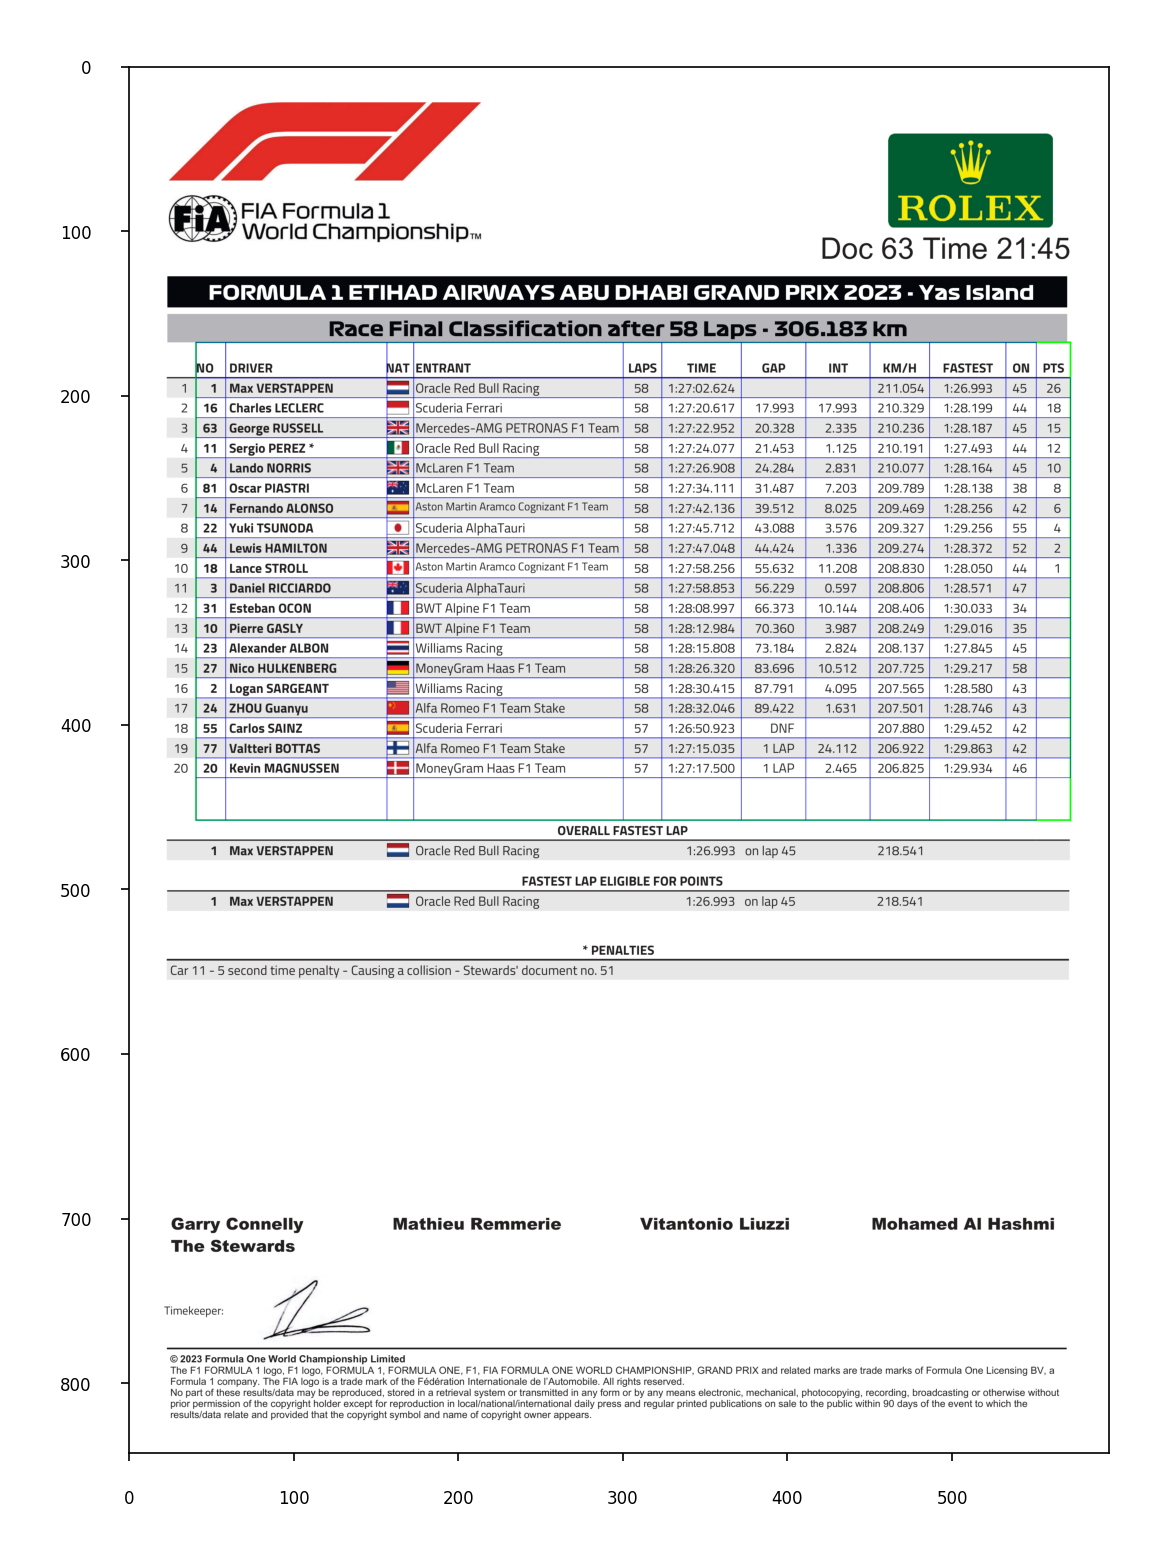

In [16]:
# Find the page with "Race Final Classification"
doc = fitz.open('../fia_pdfs/race_final_classification.pdf')
for i in range(len(doc)):
    page = doc[i]
    found = page.search_for('Race Final Classification')
    if found:
        break

# Width and height of the page
page_width, _ = page.bound()[2], page.bound()[3]

# Position of "Race Final Classification"
page_top = found[0].y1

# Position of "FASTEST LAP"
page_bottom = page.search_for('FASTEST LAP')[0].y0

# Table bounding box
bbox = fitz.Rect(0, page_top, page_width, page_bottom)

# Positions of table headers/column names
pos = {}
for col in ['NO', 'DRIVER', 'NAT', 'ENTRANT', 'LAPS', 'TIME', 'GAP', 'INT', 'KM/H', 'FASTEST',
            'ON', 'PTS']:
    pos[col] = {
        'left': page.search_for(col, clip=bbox)[0].x0,
        'right': page.search_for(col, clip=bbox)[0].x1
    }

# Lines separating the columns
aux_lines = [
    pos['NO']['left'],
    (pos['NO']['right'] + pos['DRIVER']['left']) / 2,
    pos['NAT']['left'],
    pos['NAT']['right'],
    pos['LAPS']['left'],
    pos['LAPS']['right'],
    (pos['TIME']['right'] + pos['GAP']['left']) / 2,
    (pos['GAP']['right'] + pos['INT']['left']) / 2,
    (pos['INT']['right'] + pos['KM/H']['left']) / 2,
    pos['FASTEST']['left'],
    pos['FASTEST']['right'],
    pos['PTS']['left']
]


# Find the table below "Race Final Classification"
tabs = page.find_tables(
    clip=fitz.Rect(pos['NO']['left'], page_top, page_width, page_bottom),
    strategy='lines',
    vertical_lines=aux_lines,
    snap_x_tolerance=pos['ON']['left'] - pos['FASTEST']['right']
)
# Mark the tables for visualisation
for j, tab in enumerate(tabs):  # iterate over all tables
    page.draw_rect(tab.bbox, color=fitz.pdfcolor['green'])
    for cell in tab.header.cells:
        if not cell:
            continue
        page.draw_rect(cell, color=fitz.pdfcolor['blue'], width=0.3)
    for cell in tab.cells:
        page.draw_rect(cell, color=fitz.pdfcolor['blue'], width=0.3)

show_image(page)

In [17]:
# There may be an empty row at the end. This can be seen above. 
tab.to_pandas().dropna().head()

NO           DRIVER NAT                        ENTRANT LAPS         TIME  \
0   1   Max VERSTAPPEN             Oracle Red Bull Racing   58  1:27:02.624   
1  16  Charles LECLERC                   Scuderia Ferrari   58  1:27:20.617   
2  63   George RUSSELL      Mercedes-AMG PETRONAS F1 Team   58  1:27:22.952   
3  11   Sergio PEREZ *             Oracle Red Bull Racing   58  1:27:24.077   
4   4     Lando NORRIS                    McLaren F1 Team   58  1:27:26.908   

      GAP     INT     KM/H   FASTEST  ON Col11  
0                  211.054  1:26.993  45    26  
1  17.993  17.993  210.329  1:28.199  44    18  
2  20.328   2.335  210.236  1:28.187  45    15  
3  21.453   1.125  210.191  1:27.493  44    12  
4  24.284   2.831  210.077  1:28.164  45    10

Have one empty row in the end, not a big problem; can drop it easily. Also drivers who received a penalty have an asterisk next to their name, which may need to be removed.

### OVERALL FASTEST LAP

Find the text "OVERALL FASTEST LAP" and "FASTEST LAP ELIGIBLE FOR POINTS". The fastest lap is between the top.

1
Max VERSTAPPEN
Oracle Red Bull Racing
1:26.993 on lap 45
218.541


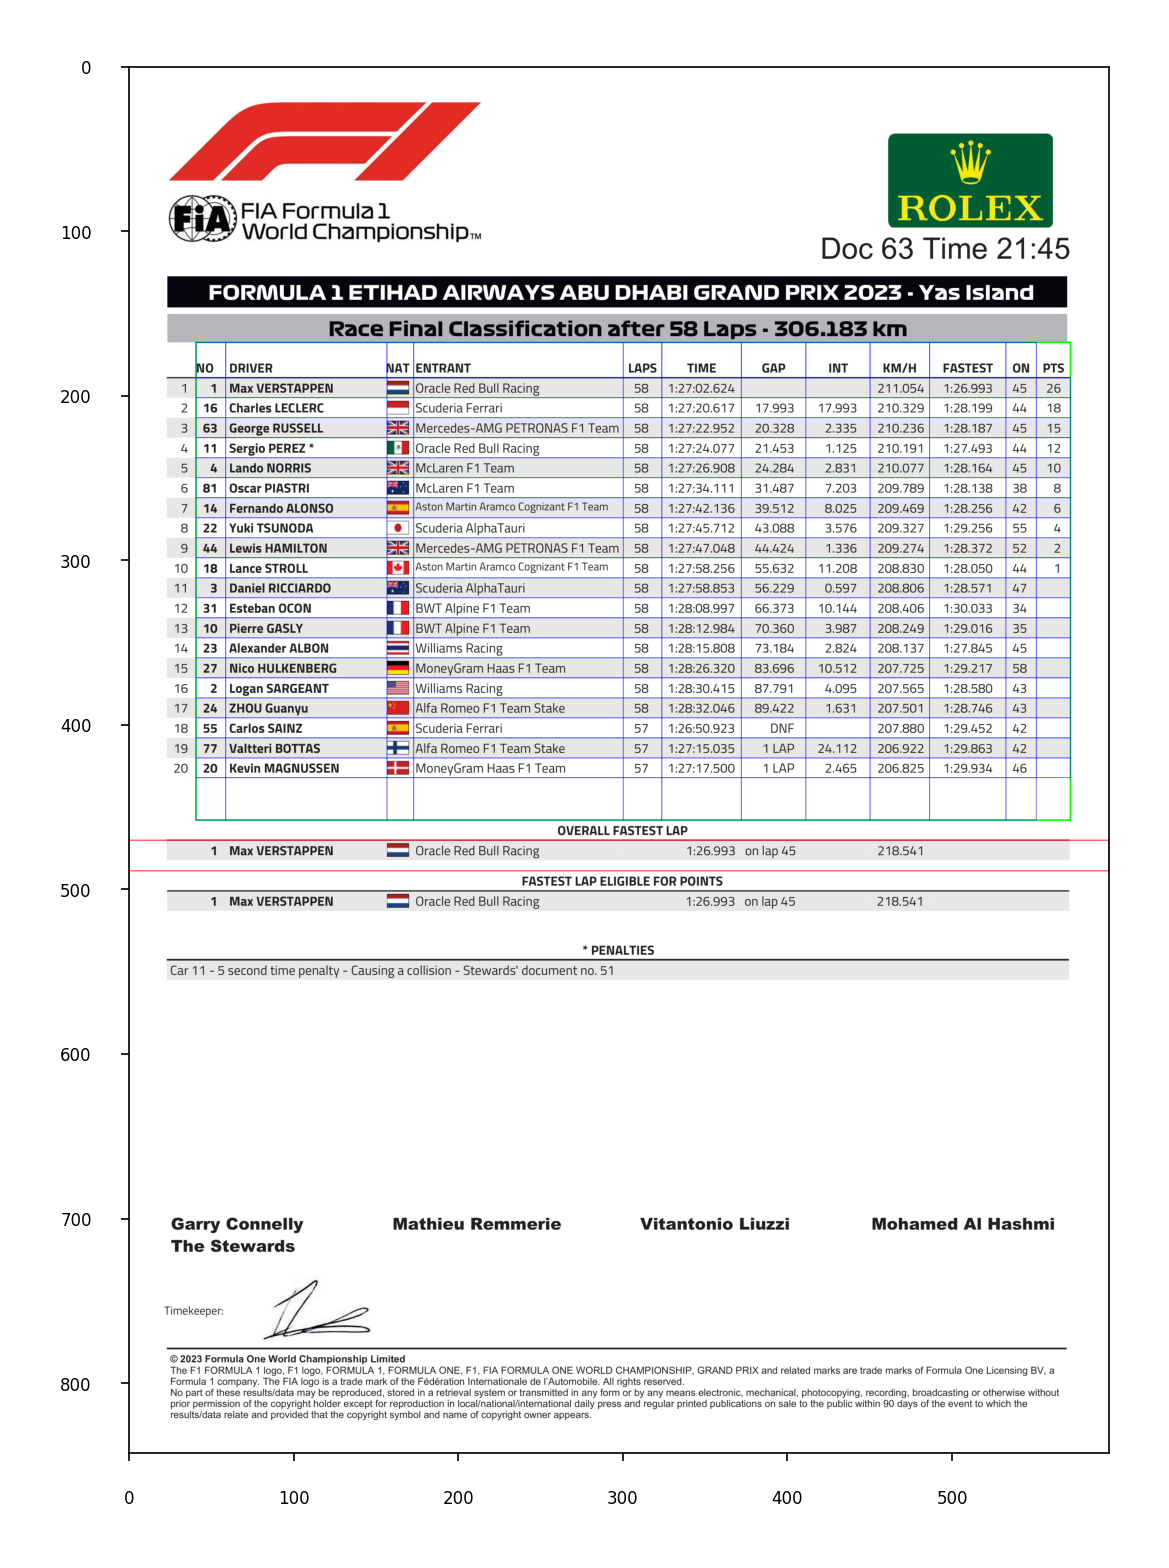

In [18]:
# Find the positions of "OVERALL FASTEST LAP" and "FASTEST LAP ELIGIBLE FOR POINTS"
t = page.search_for('OVERALL FASTEST LAP')[0].y1
b = page.search_for('FASTEST LAP ELIGIBLE FOR POINTS')[0].y0
fastest_lap = page.get_text('block', clip=fitz.Rect(0, t, w, b)).strip()
print(fastest_lap)
page.draw_rect(fitz.Rect(0, t, w, b), color=fitz.pdfcolor['red'], width=0.5)
show_image(page)

### Fastest Lap eligible for points

Same intuition: the text is betweem "FASTEST LAP ELIGIBLE FOR POINTS" and "PENALTIES".

1
Max VERSTAPPEN
Oracle Red Bull Racing
1:26.993  on lap 45
218.541


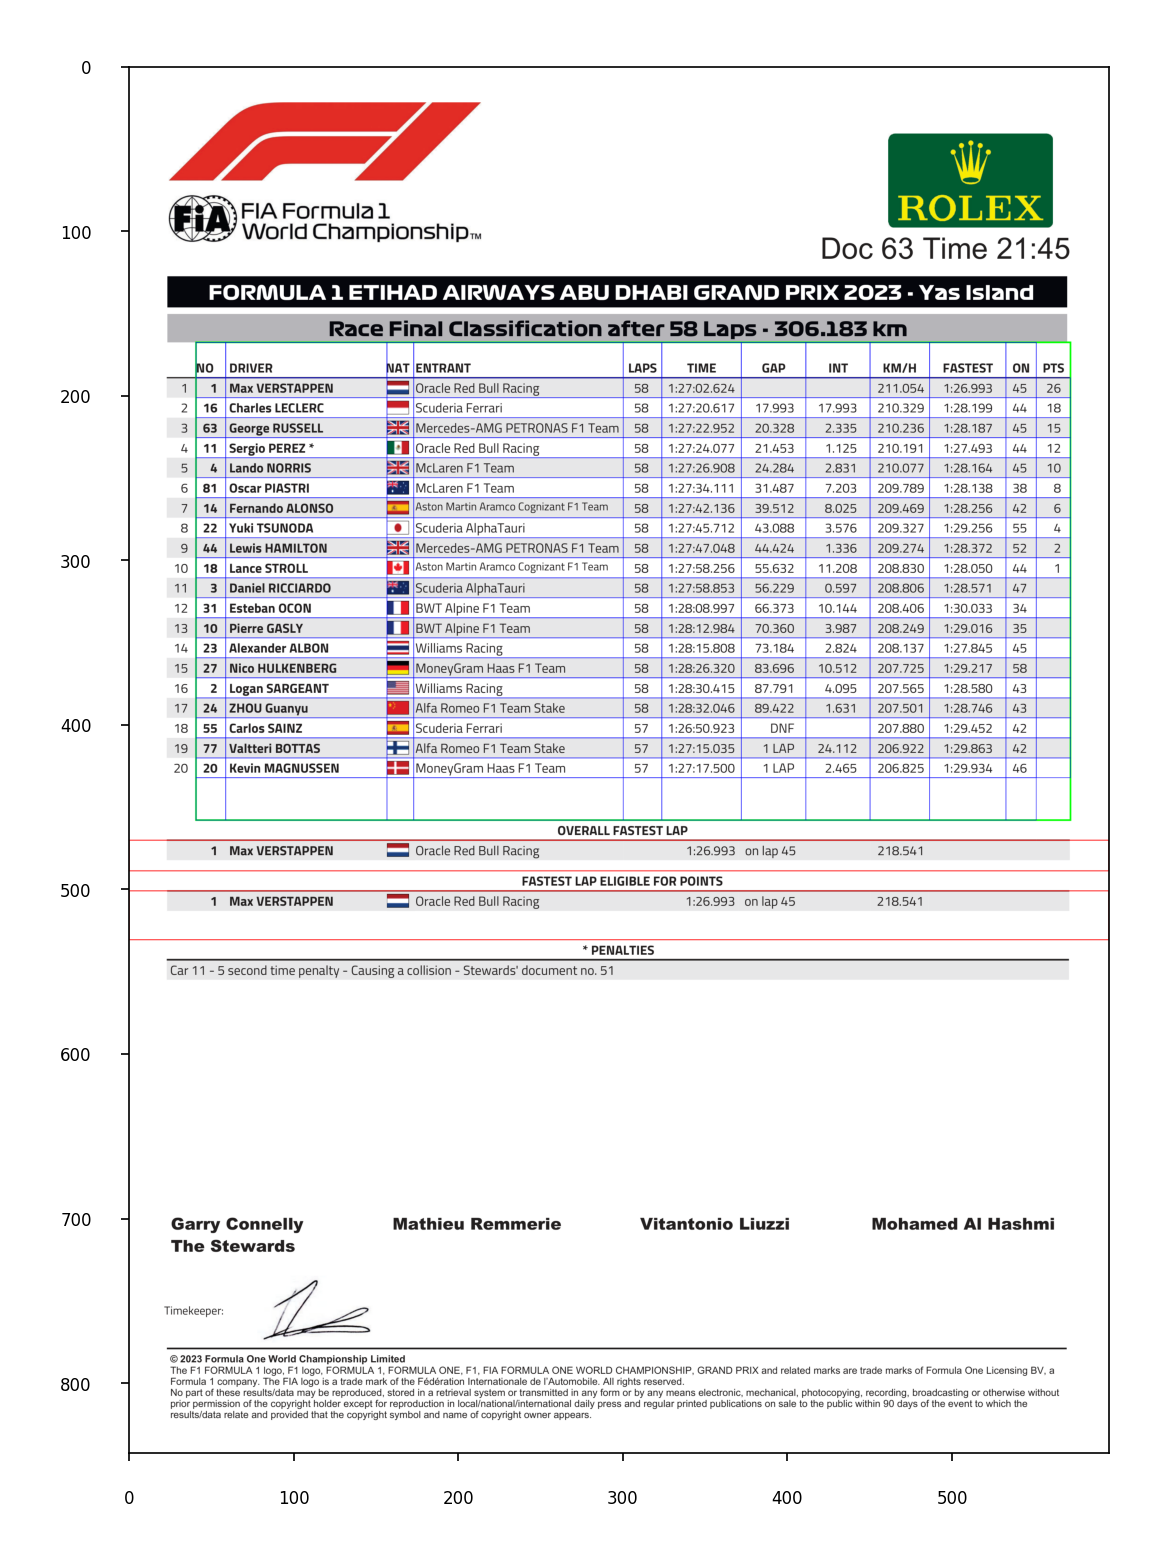

In [19]:
t = page.search_for('FASTEST LAP ELIGIBLE FOR POINTS')[0].y1
b = page.search_for('PENALTIES')[0].y0
fastest_lap = page.get_text('block', clip=fitz.Rect(0, t, w, b)).strip()
print(fastest_lap)
page.draw_rect(fitz.Rect(0, t, w, b), color=fitz.pdfcolor['red'], width=0.5)
show_image(page)

## Penalties

Everything below "PENALTIES" and above "Timekeeper". We may accidentally include the stewards, but in a penalty there must be a decision document number, which is basically some digits, while stewards' names will not have digits, so can easily remove them.

Car 11 - 5 second time penalty - Causing a collision - Stewards' document no. 51
Garry Connelly
        Mathieu Remmerie
          Vitantonio Liuzzi
         Mohamed Al Hashmi 
The Stewards


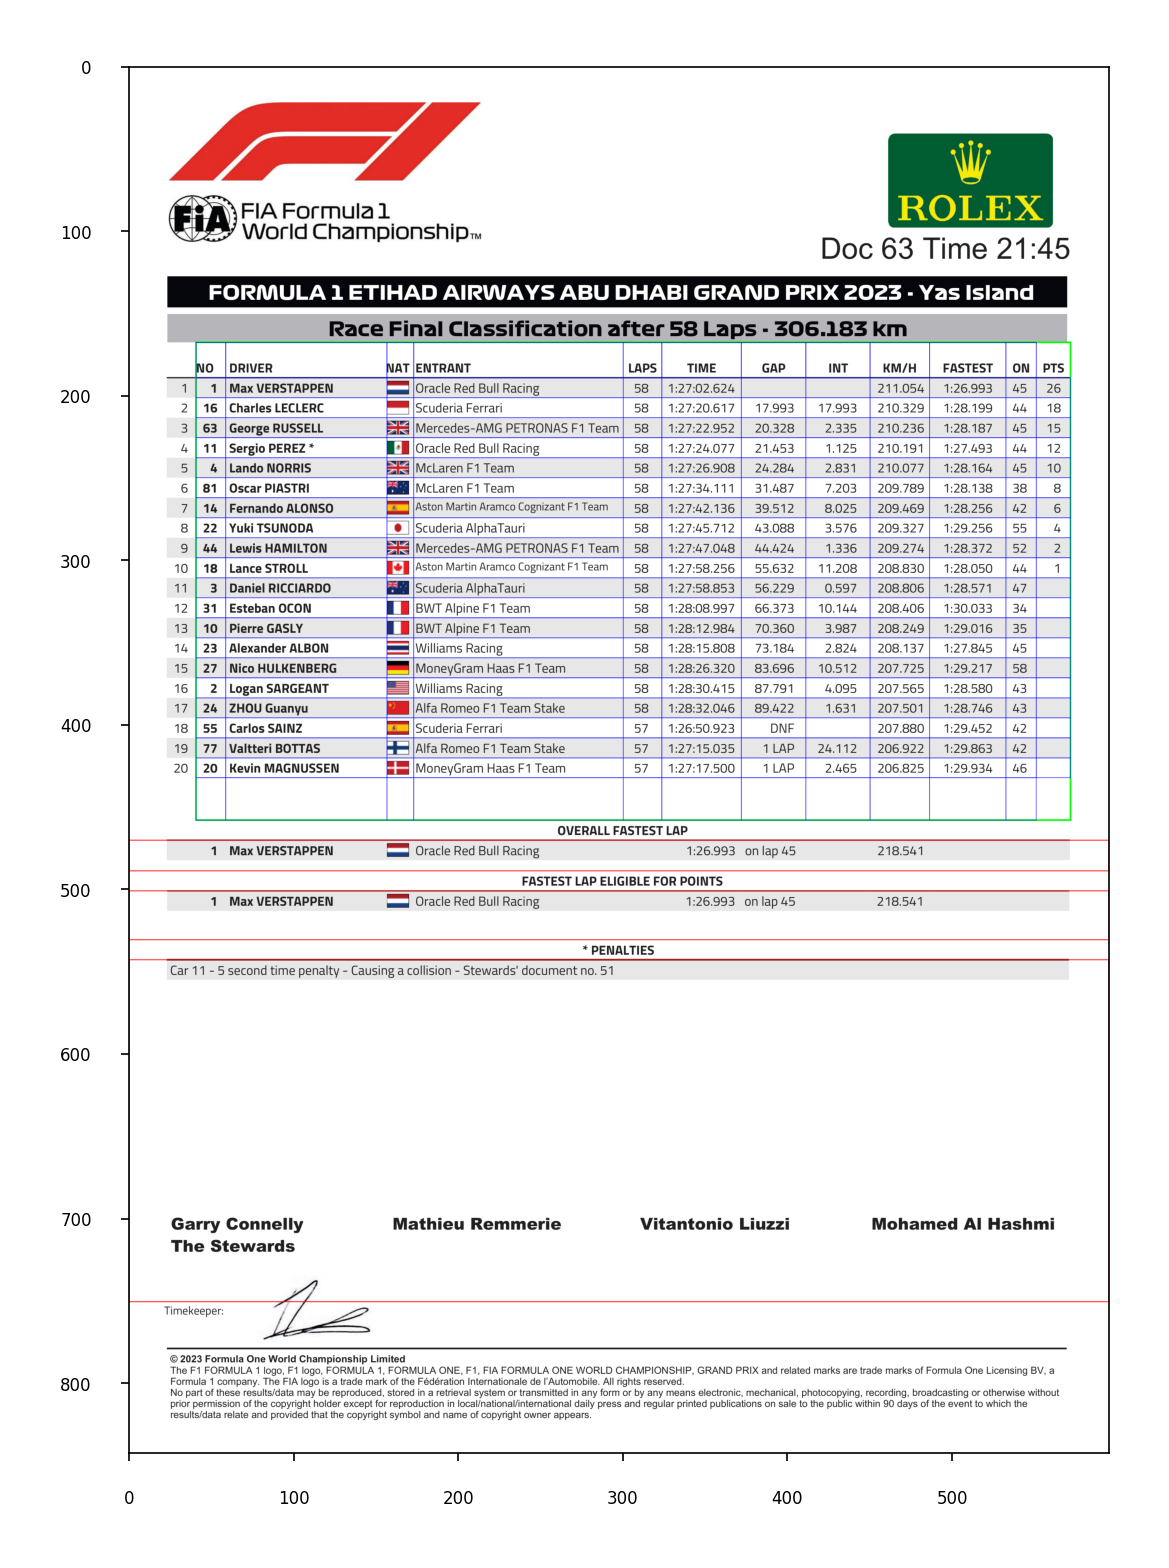

In [20]:
t = page.search_for('PENALTIES')[0].y1
b = page.search_for('Timekeeper')[0].y0
penalties = page.get_text('block', clip=fitz.Rect(0, t, w, b)).strip()
page.draw_rect(fitz.Rect(0, t, w, b), color=fitz.pdfcolor['red'], width=0.5)
print(penalties)
show_image(page)

In [21]:
for i in penalties.split('\n'):
    if re.findall(r'\d+', i):
        print(i)

Car 11 - 5 second time penalty - Causing a collision - Stewards' document no. 51


## Race Best Sector

Find "Sector $i$" and "Sector $i + 1$" (or the right edge of the page). The table for sector $i$ is below the two words, and bounded between the left of "Sector $i$" and the left of "Sector $i + 1$".

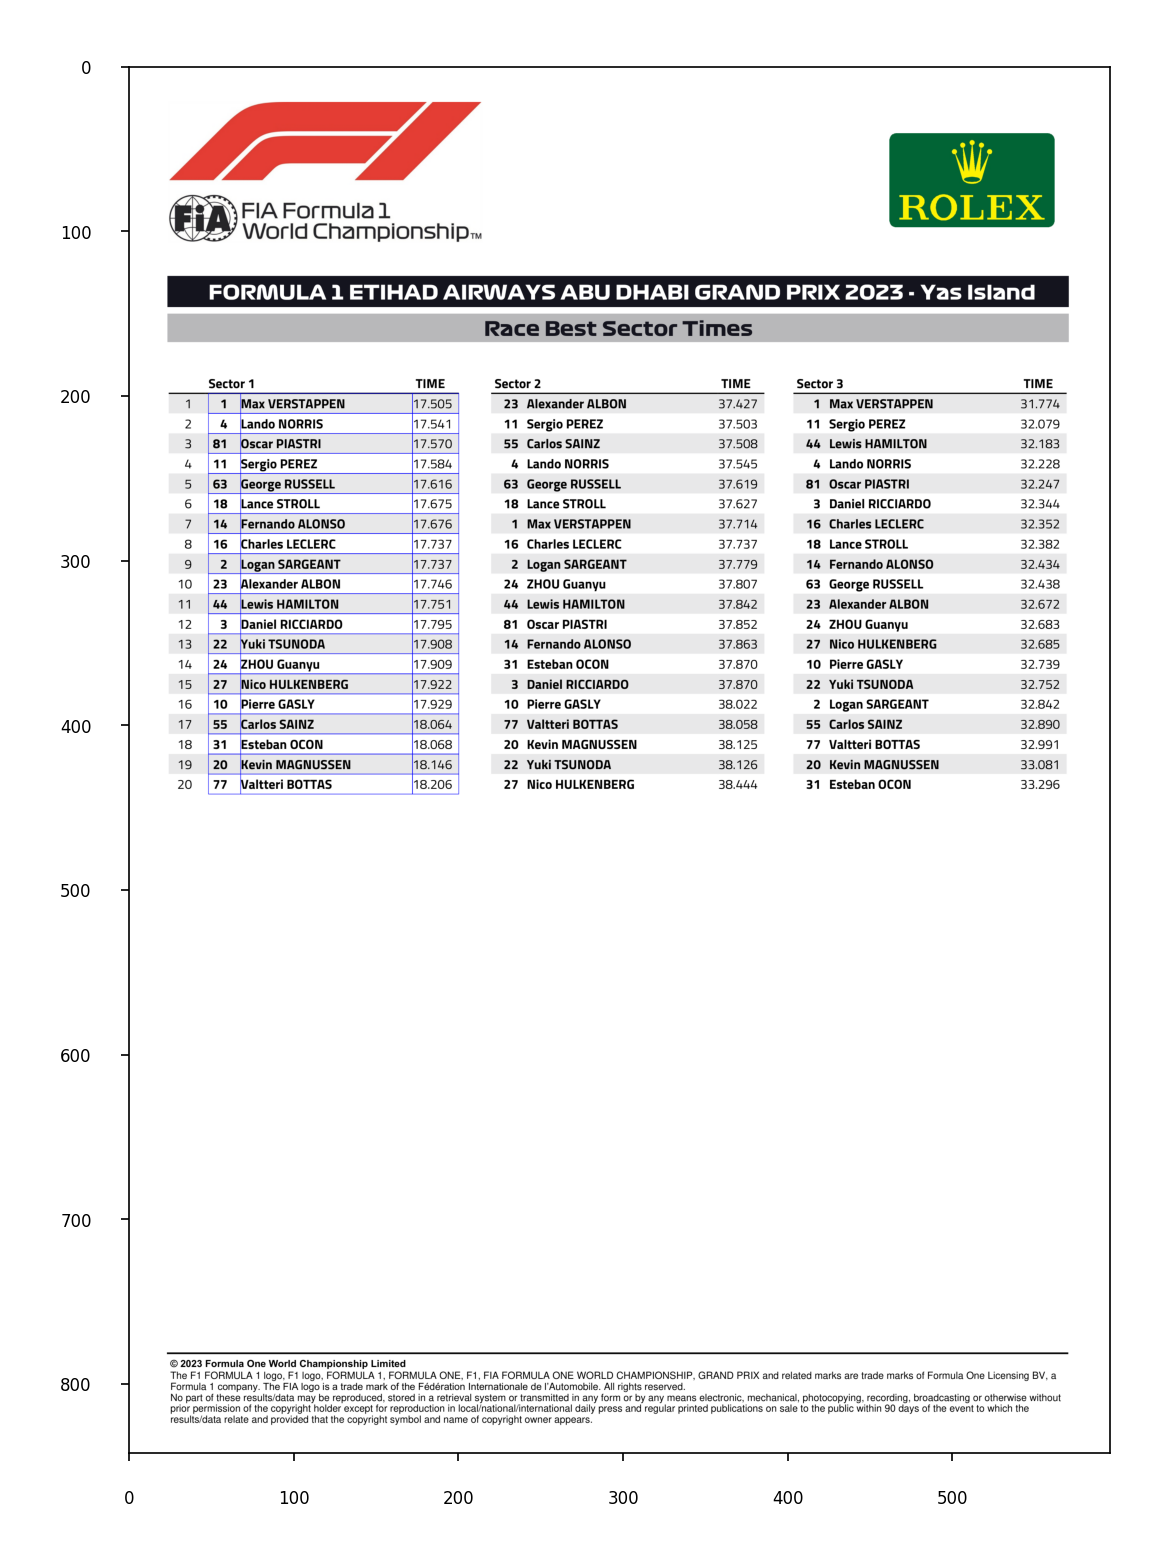

In [22]:
doc = fitz.open('../fia_pdfs/race_best_sector_times.pdf')
page = doc[0]

# Find "Sector 1" and "TIME"
sector = page.search_for('Sector 1')[0]
t = sector.y1
l = sector.x0
r = page.search_for('Sector 2')[0].x0

# Find the total height of the page
b = page.bound()[3]

# Find the table below "Sector 1" and "TIME"
tab = page.find_tables(clip=fitz.Rect(l, t, r, b), strategy='lines',
                       add_lines=[((l, 0), (l, b))])[0]
for cell in tab.cells:
    page.draw_rect(cell, color=fitz.pdfcolor['blue'], width=0.3)
show_image(page)

In [23]:
df = tab.to_pandas()
df.index += 1  # Didn't parse the header correctly, and the winner is treated as the header. Fix it
df.iloc[0] = df.columns
df.columns = ['NO', 'DRIVER', 'TIME']
df

NO            DRIVER    TIME
1    1    Max VERSTAPPEN  17.505
2   81     Oscar PIASTRI  17.570
3   11      Sergio PEREZ  17.584
4   63    George RUSSELL  17.616
5   18      Lance STROLL  17.675
6   14   Fernando ALONSO  17.676
7   16   Charles LECLERC  17.737
8    2    Logan SARGEANT  17.737
9   23   Alexander ALBON  17.746
10  44    Lewis HAMILTON  17.751
11   3  Daniel RICCIARDO  17.795
12  22      Yuki TSUNODA  17.908
13  24       ZHOU Guanyu  17.909
14  27   Nico HULKENBERG  17.922
15  10      Pierre GASLY  17.929
16  55      Carlos SAINZ  18.064
17  31      Esteban OCON  18.068
18  20   Kevin MAGNUSSEN  18.146
19  77   Valtteri BOTTAS  18.206

## Race Fastest Laps

Very similar with Race Final Classification.

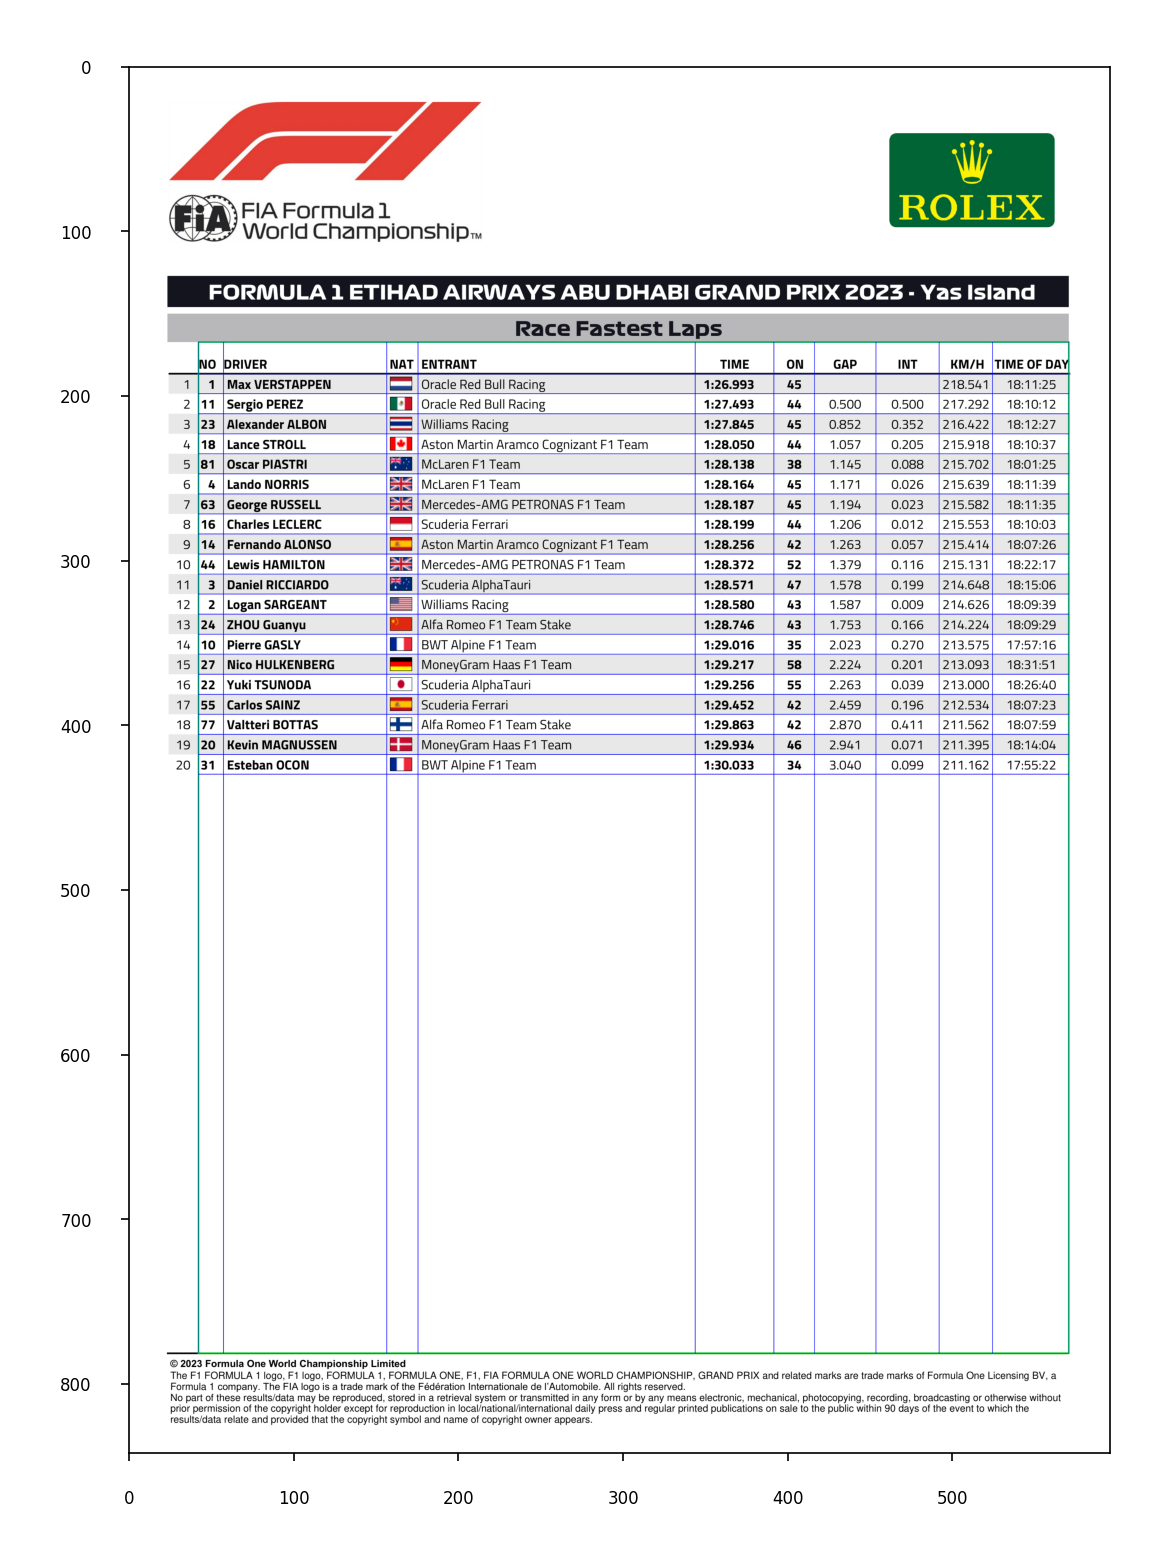

In [24]:
doc = fitz.open('../fia_pdfs/race_fastest_laps.pdf')
page = doc[0]

# Height and width of the page
h, w = page.bound()[3], page.bound()[2]

# Find "Race Fastest Lap"
t = page.search_for('Race Fastest Laps')[0].y1

# Find "TIME OF DAY"
b = page.search_for('TIME OF DAY')[0].y1

# Positions of table headers/column names
bbox = fitz.Rect(0, t, w, b)
pos = {}
for col in ['NO', 'DRIVER', 'NAT', 'ENTRANT', 'TIME', 'ON', 'GAP', 'INT', 'KM/H', 'TIME OF DAY']:
    pos[col] = {
        'left': page.search_for(col, clip=bbox)[0].x0,
        'right': page.search_for(col, clip=bbox)[0].x1
    }

# Lines separating the columns
aux_lines = [
    pos['NO']['left'],
    pos['DRIVER']['left'],
    pos['NAT']['left'],
    pos['NAT']['right'],
    pos['TIME']['left'] - (pos['TIME']['right'] - pos['TIME']['left']),
    (pos['TIME']['right'] + pos['ON']['left']) / 2,
    (pos['ON']['right'] + pos['GAP']['left']) / 2,
    (pos['GAP']['right'] + pos['INT']['left']) / 2,
    (pos['INT']['right'] + pos['KM/H']['left']) / 2,
    pos['TIME OF DAY']['left'],
    pos['TIME OF DAY']['right']
]


# Find the table below "Race Final Classification"
tab = page.find_tables(
    clip=fitz.Rect(pos['NO']['left'], t, pos['TIME OF DAY']['right'], h),
    strategy='lines',
    vertical_lines=aux_lines,
    snap_x_tolerance=pos['ENTRANT']['left'] - pos['NAT']['right']
)[0]

# Mark the tables for visualisation
page.draw_rect(tab.bbox, color=fitz.pdfcolor['green'])
for cell in tab.cells:
    page.draw_rect(cell, color=fitz.pdfcolor['blue'], width=0.3)
show_image(page)

In [25]:
tab.to_pandas().head()

NO           DRIVER NAT                                ENTRANT      TIME  \
0   1   Max VERSTAPPEN                     Oracle Red Bull Racing  1:26.993   
1  11     Sergio PEREZ                     Oracle Red Bull Racing  1:27.493   
2  23  Alexander ALBON                            Williams Racing  1:27.845   
3  18     Lance STROLL      Aston Martin Aramco Cognizant F1 Team  1:28.050   
4  81    Oscar PIASTRI                            McLaren F1 Team  1:28.138   

   ON    GAP    INT     KM/H TIME OF DAY  
0  45                218.541    18:11:25  
1  44  0.500  0.500  217.292    18:10:12  
2  45  0.852  0.352  216.422    18:12:27  
3  44  1.057  0.205  215.918    18:10:37  
4  38  1.145  0.088  215.702    18:01:25

## Race History Chart

There are multiple tables in each page, all of which are below "Race History Chart". The table for lap $i$ is horizontally bounded between "Lap $i$" and "Lap $i + 1$" (or the right border of the page).

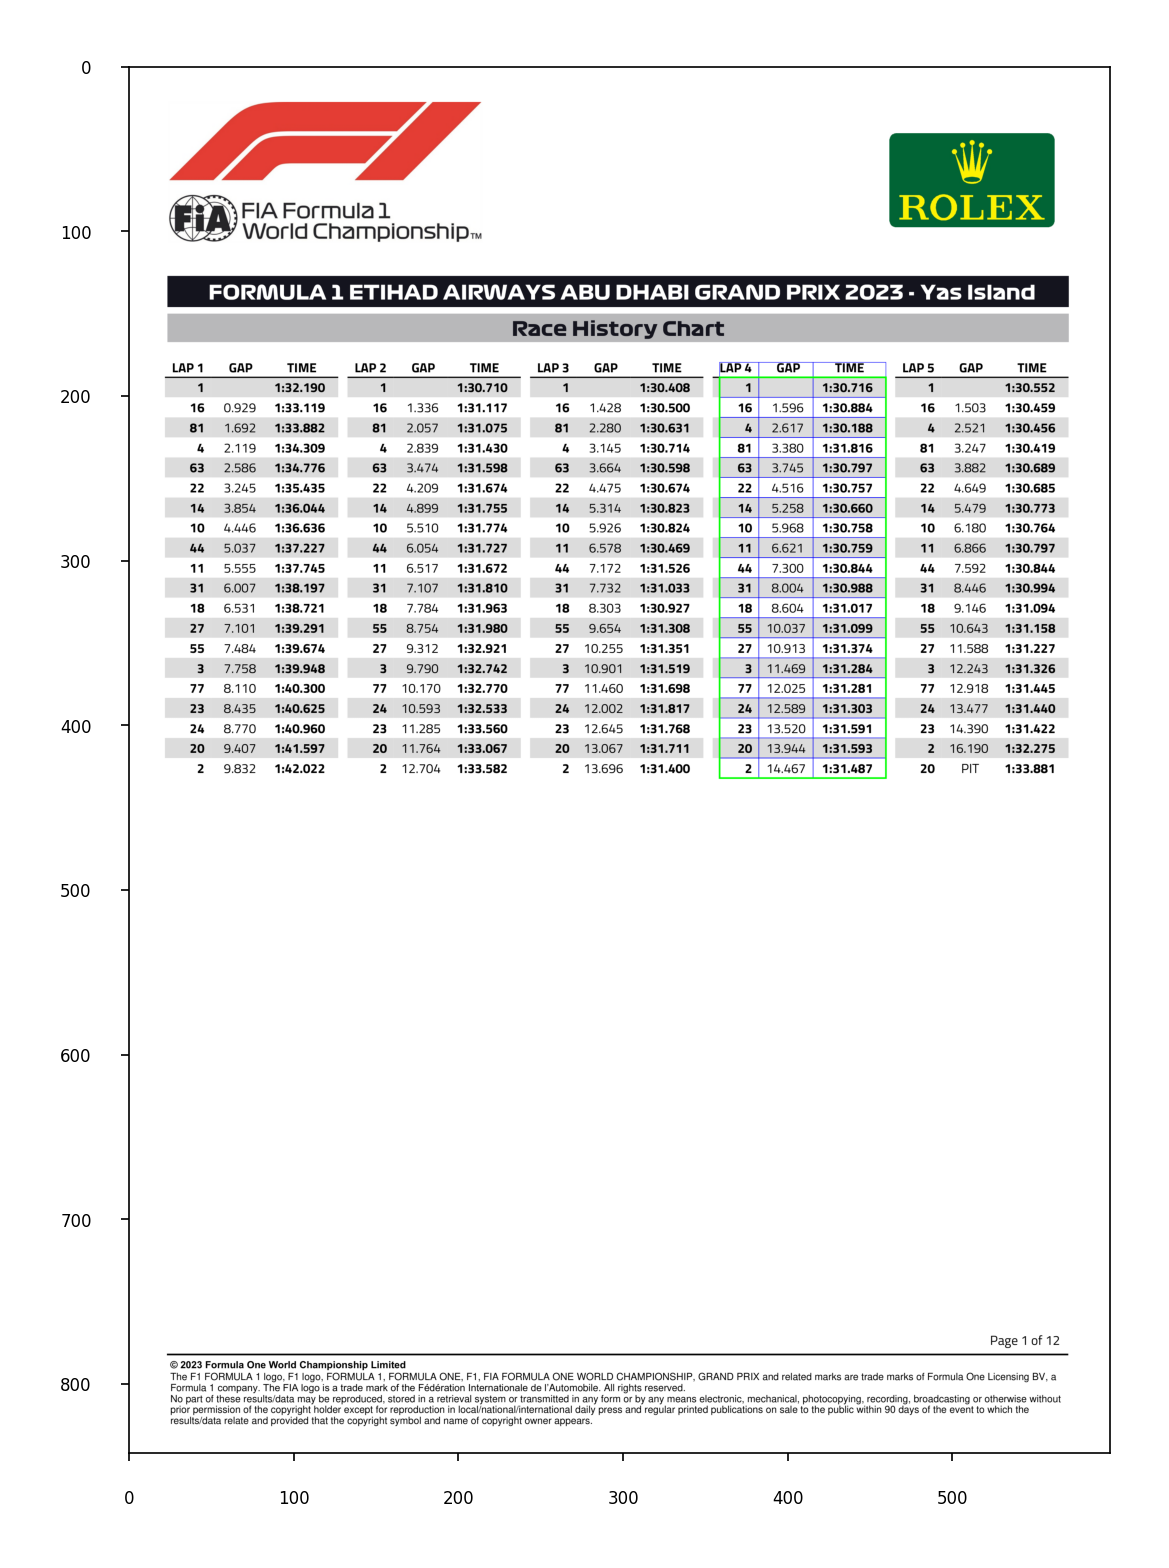

In [26]:
doc = fitz.open('../fia_pdfs/race_history_chart.pdf')
page = doc[0]

# Find "Race History Chart"
t = page.search_for('Race History Chart')[0].y1

# Page width and height
w, h = page.bound()[2], page.bound()[3]

# Find the table for lap 4 as an example
for i in range(4, 5):

    # Find "Lap 4"
    l = page.search_for(f'Lap {i}')[0].x0

    # Find "Lap 5"
    if page.search_for(f'Lap {i + 1}'):
        r = page.search_for(f'Lap {i + 1}')[0].x0
    else:
        r = w

    # Find tables in the bounding box of driver i's table
    tab = page.find_tables(clip=fitz.Rect(l, t, r, h), strategy='lines',
                           add_lines=[((l, 0), (l, h))])[0]

    # Mark the tables for visualisation
    for cell in tab.header.cells:
        page.draw_rect(cell,color=fitz.pdfcolor['blue'],width=0.3)
    for cell in tab.cells:
        page.draw_rect(cell,color=fitz.pdfcolor['blue'],width=0.3)
    page.draw_rect(tab.bbox, color=fitz.pdfcolor['green'])

show_image(page)

In [27]:
tab.to_pandas().head()

LAP 4    GAP      TIME
0     1         1:30.716
1    16  1.596  1:30.884
2     4  2.617  1:30.188
3    81  3.380  1:31.816
4    63  3.745  1:30.797

## Race Maximum Speeds

A table is horizontally bounded between words like "FINISH LINE" and "KM/H". To help parsing, we add column seprators at the table's left border, the left of "KM/H", and the right border of the table.

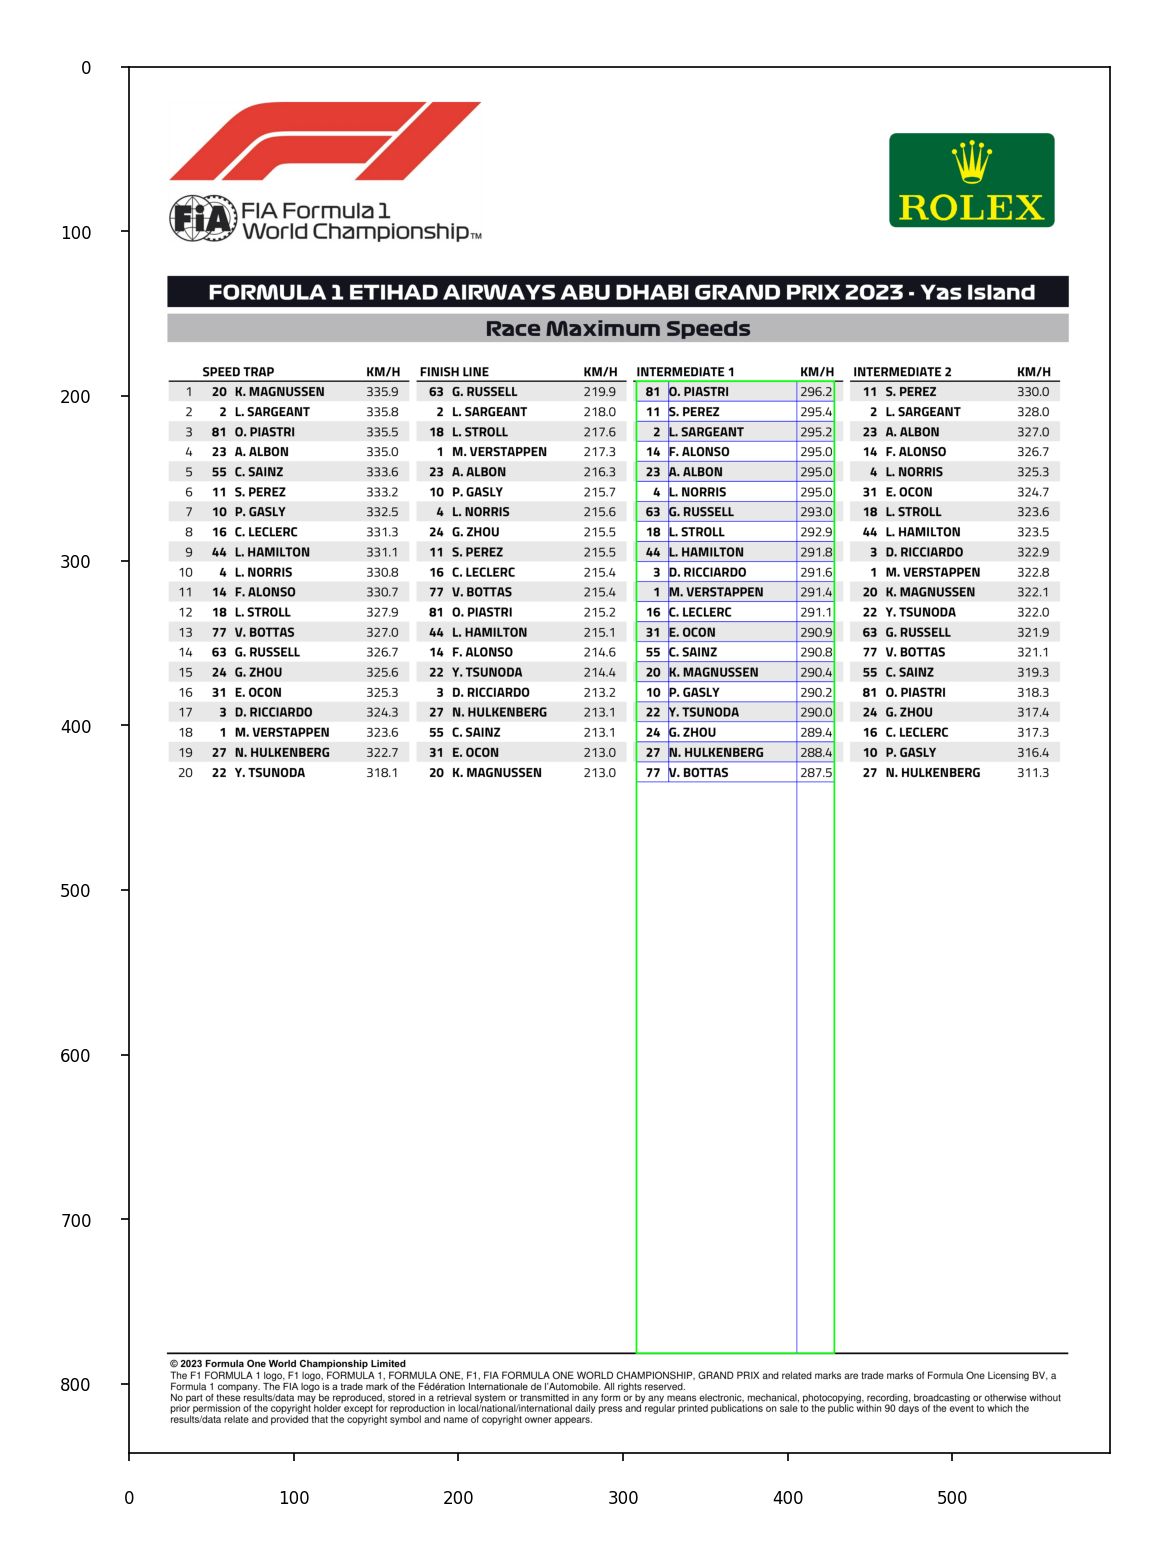

In [28]:
doc = fitz.open('../fia_pdfs/race_maximum_speeds.pdf')
page = doc[0]

# Find "KM/H"
t = page.search_for('KM/H')[0].y0

# Page width and height
w, h = page.bound()[2], page.bound()[3]
tabs = page.find_tables(clip=fitz.Rect(0, t, w, h), strategy='lines')

# Search for the table of "Intermediate 1"
for i in ['INTERMEDIATE 1']:
    l = page.search_for(i)[0].x0
    kmh = page.search_for('KM/H', clip=fitz.Rect(l, t, w, h))[0]
    r = kmh.x1
    aux_lines = [
        ((kmh.x0, t), (kmh.x0, h)),
        ((r, t), (r, h))
    ]
    tab = page.find_tables(clip=fitz.Rect(l, t, r, h), strategy='lines',
                           vertical_lines=[l, kmh.x0, r])[0]
    for cell in tab.cells:
        page.draw_rect(cell,color=fitz.pdfcolor['blue'],width=0.3)
    page.draw_rect(tab.bbox, color=fitz.pdfcolor['green'])

show_image(page)

Again, the header is lost so add it manually.

In [29]:
df = tab.to_pandas()
df.index += 1  # Didn't parse the header correctly, and the winner is treated as the header. Fix it
df.iloc[0] = df.columns
df.columns = ['NO', 'DRIVER', 'KM/H']
df.dropna(subset='DRIVER').head()

NO       DRIVER   KM/H
1  81   O. PIASTRI  296.2
2   2  L. SARGEANT  295.2
3  14    F. ALONSO  295.0
4  23     A. ALBON  295.0
5   4    L. NORRIS  295.0

## Race Pit Stop Summary

The table is below "Race Pit Stop Summary". The columns are separated by the left border of the page, and of the words "NO", "DRIVER", "ENTRANT", "LAP", "TIME OF DAY", "STOP", "DURATION", "TOTAL TIME", and right border of the page.

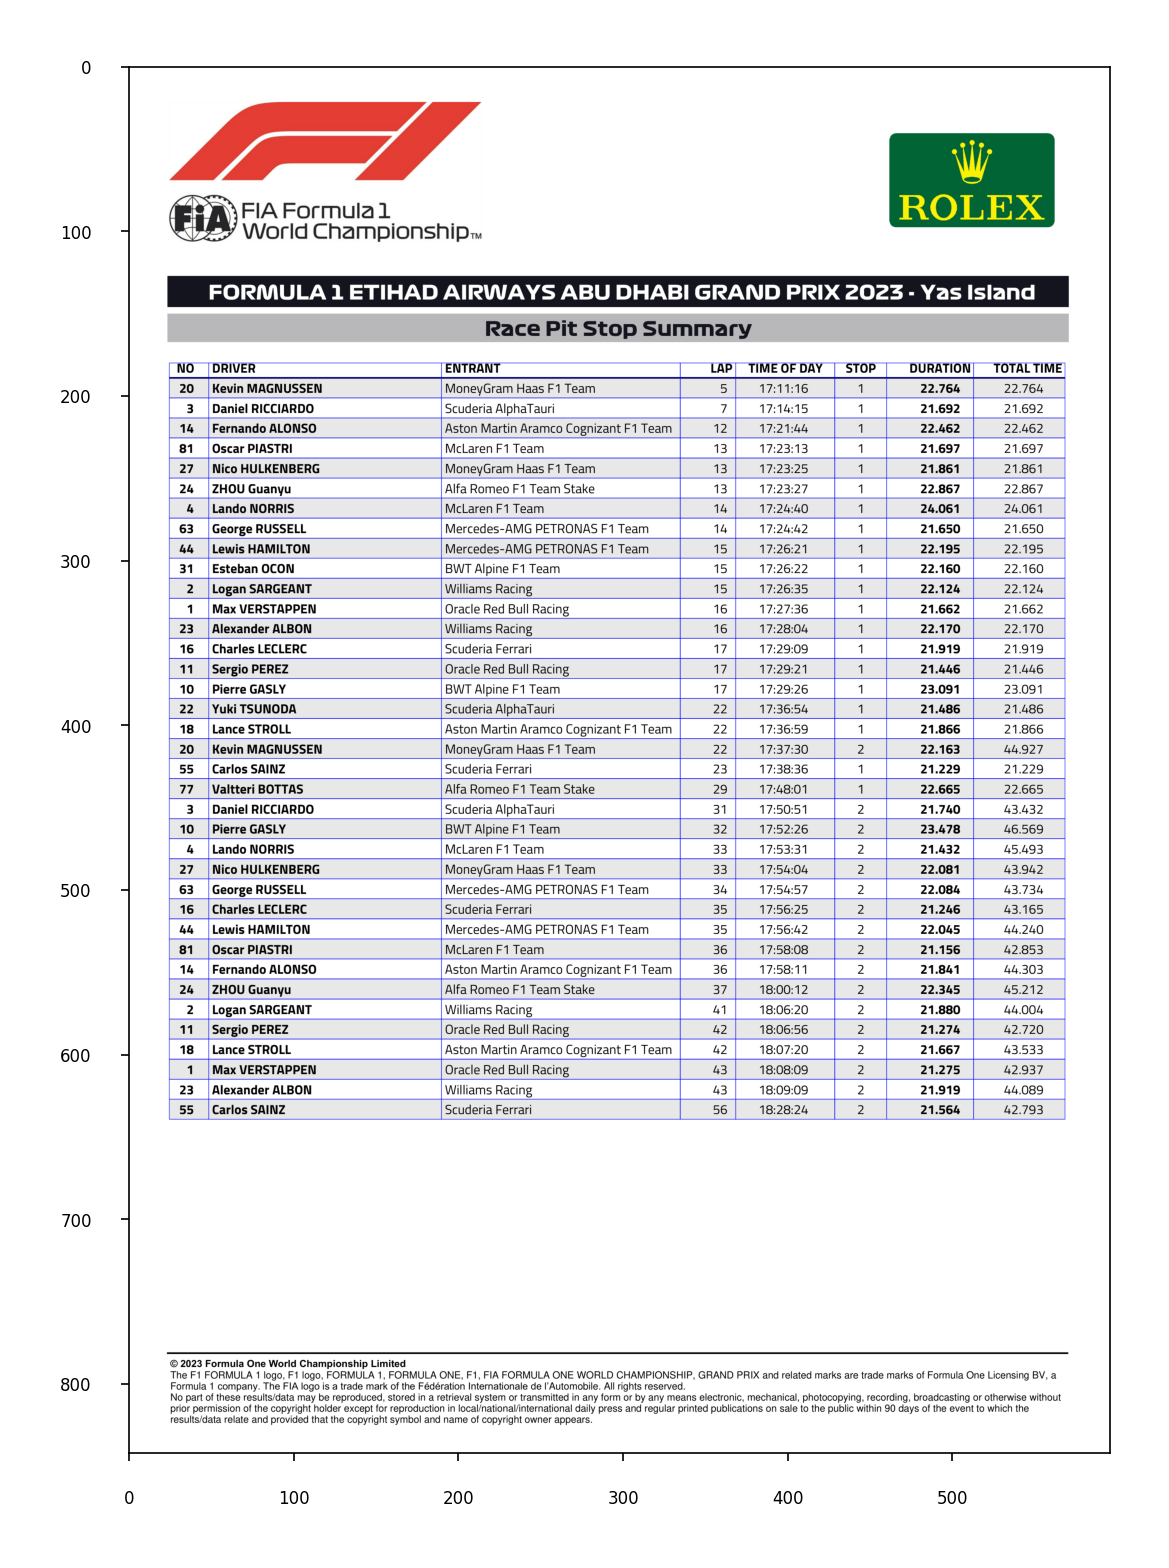

In [30]:
doc = fitz.open('../fia_pdfs/race_pit_stop_summary.pdf')
page = doc[0]

# Find "Race Pit Stop Summary"
t = page.search_for('DRIVER')[0].y0

# Page width and height
w, h = page.bound()[2], page.bound()[3]

tabs = page.find_tables(clip=fitz.Rect(0, t, w, h), strategy='lines')
for tab in tabs:
    for cell in tab.header.cells:
        page.draw_rect(cell, color=fitz.pdfcolor['blue'], width=0.3)
    for cell in tab.cells:
        page.draw_rect(cell, color=fitz.pdfcolor['blue'], width=0.3)
show_image(page)

In [31]:
tabs[0].to_pandas().head()

NO            DRIVER                                ENTRANT LAP  \
0  20   Kevin MAGNUSSEN                 MoneyGram Haas F1 Team   5   
1   3  Daniel RICCIARDO                    Scuderia AlphaTauri   7   
2  14   Fernando ALONSO  Aston Martin Aramco Cognizant F1 Team  12   
3  81     Oscar PIASTRI                        McLaren F1 Team  13   
4  27   Nico HULKENBERG                 MoneyGram Haas F1 Team  13   

  TIME OF DAY STOP DURATION TOTAL TIME  
0    17:11:16    1   22.764     22.764  
1    17:14:15    1   21.692     21.692  
2    17:21:44    1   22.462     22.462  
3    17:23:13    1   21.697     21.697  
4    17:23:25    1   21.861     21.861

## Race Lap Chart

This is probably the most structured table, but cannot be easily parsed, bc. some numbers are boxed and the boxes are essentially lines, which interfere with table structure detection. So instead, we don't use any vector graphics for parsing, but only use text positions, i.e. `strategy='text'`.

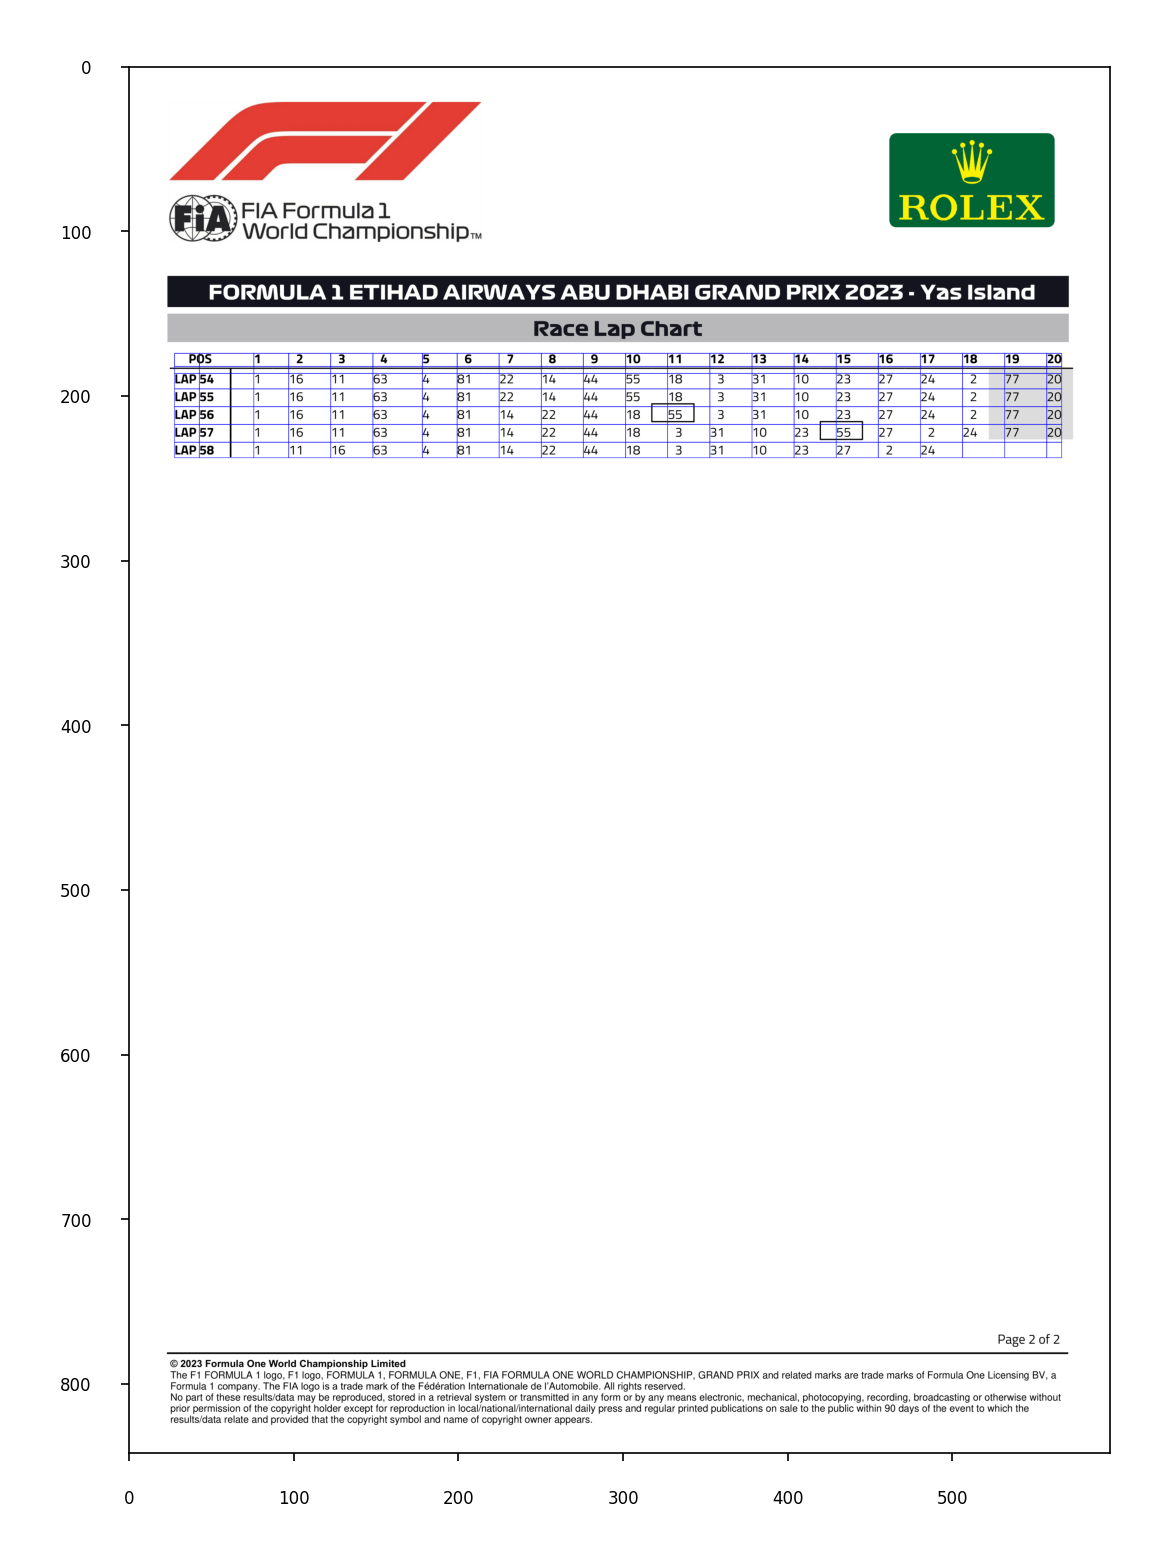

In [32]:
doc = fitz.open('../fia_pdfs/race_lap_chart.pdf')
page = doc[1]

# Find "POS"
t = page.search_for('POS')[0].y0

# Find "Page"
b = page.search_for('Page')[0].y0

# Page width
w = page.bound()[2]

tabs = page.find_tables(clip=fitz.Rect(0, t, w, b), strategy='text')
for tab in tabs:
    for cell in tab.header.cells:
        page.draw_rect(cell, color=fitz.pdfcolor['blue'], width=0.3)
    for cell in tab.cells:
        page.draw_rect(cell, color=fitz.pdfcolor['blue'], width=0.3)
show_image(page)

We lose a bit in column 0 (e.g. get "AP 5" rather than "LAP 5), but that's fine. We only need the lap number, which is at most two digits, and thus definitely contained within the width of "POS". It's OK to lose "LAP".

In [33]:
tabs[0].to_pandas()

P  OS  1   2   3   4  5   6   7   8  ...  11  12  13  14  15  16  17  18  \
0                                         ...                                   
1  LAP  54  1  16  11  63  4  81  22  14  ...  18   3  31  10  23  27  24   2   
2  LAP  55  1  16  11  63  4  81  22  14  ...  18   3  31  10  23  27  24   2   
3  LAP  56  1  16  11  63  4  81  14  22  ...  55   3  31  10  23  27  24   2   
4  LAP  57  1  16  11  63  4  81  14  22  ...   3  31  10  23  55  27   2  24   
5  LAP  58  1  11  16  63  4  81  14  22  ...   3  31  10  23  27   2  24       

   19  20  
0          
1  77  20  
2  77  20  
3  77  20  
4  77  20  
5          

[6 rows x 22 columns]

# Stuff that doesn't work

* table transformer (Smock et al., CVPR [2022](https://arxiv.org/pdf/2110.00061.pdf))
    + it does not recognise the table structure at all... I'm following this [notebook](https://github.com/NielsRogge/Transformers-Tutorials/blob/master/Table%20Transformer/Using_Table_Transformer_for_table_detection_and_table_structure_recognition.ipynb); maybe something wrong with my code?